In [1]:
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sleep_data = pd.read_csv('Longitudinal sleep.csv')
volumes_data = pd.read_csv('Volumes_merge.csv')

In [3]:
volumes_data = volumes_data.drop(['Month','Years_bl','AGE'],axis=1)

In [4]:
sleep_data.rename(columns={"VISCODE2": "VISCODE"}, inplace=True)

In [5]:
sleep_bl = sleep_data[sleep_data['VISCODE'] == 'bl']
volumes_bl = volumes_data[volumes_data['VISCODE'] == 'bl']

In [6]:
data_bl = pd.merge(sleep_bl, volumes_bl, on=[
                    'RID', 'VISCODE'], how='inner')

In [7]:
data_bl.head()

,RID,VISCODE,NPIK,NPIKSEV,MHDESC,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other,Sleep_Quality,...,MHPSYCH,MH2NEURL,MH4CARD,MH5RESP,MH19OTHR,ADNI_MEM,ADNI_EF,ADNI_VS,ADNI_LAN,ADNI_EF2
0,3,bl,0.0,-4.0,1995-hypertension; 1995-hyperlipidemia; 2000-o...,0,0,0,0,No Significant Sleep Disturbance,...,0,0,1,0,0,-1.021,-1.144,-0.880,-1.368,-1.062
1,5,bl,0.0,-4.0,2000 glaucoma; 1941-Rosacea; 1995-ulcer; smoke...,0,0,0,0,No Significant Sleep Disturbance,...,0,0,0,0,0,0.743,0.165,0.739,0.259,-0.152
2,10,bl,0.0,-4.0,2004- depressive symptoms; 2000-alzheimer dise...,0,0,0,0,No Significant Sleep Disturbance,...,1,1,0,1,1,-0.739,-0.464,-1.388,0.611,-0.882
3,14,bl,0.0,-4.0,Depression in 1988. Treated with antidepressan...,0,0,0,0,No Significant Sleep Disturbance,...,1,0,0,0,0,0.901,-0.202,-0.080,0.169,-0.377
4,16,bl,0.0,-4.0,"2003 glaucoma; 1994 asthma, 1998 collapsed lun...",0,0,0,0,No Significant Sleep Disturbance,...,0,0,1,1,1,0.469,0.513,-0.548,0.401,0.406


In [8]:
print(data_bl.columns.tolist())

['RID', 'VISCODE', 'NPIK', 'NPIKSEV', 'MHDESC', 'Sleep_Apnea', 'Restless_Legs', 'Insomnia', 'Sleep_Disturbance_Other', 'Sleep_Quality', 'Brainstem', 'CorpusCallosumAnterior', 'CorpusCallosumCentral', 'CorpusCallosumMidAnterior', 'CorpusCallosumMidPosterior', 'CorpusCallosumPosterior', 'Csf', 'RightParacentral', 'RightParahippocampal', 'RightParsOpercularis', 'RightParsOrbitalis', 'RightParsTriangularis', 'RightPericalcarine', 'RightPostcentral', 'RightPosteriorCingulate', 'RightPrecentral', 'RightPrecuneus', 'RightRostralAnteriorCingulate', 'RightRostralMiddleFrontal', 'RightSuperiorFrontal', 'RightSuperiorParietal', 'RightSuperiorTemporal', 'RightSupramarginal', 'RightTemporalPole', 'RightTransverseTemporal', 'RightUnknown', 'LeftInsula', 'RightInsula', 'LeftBankssts', 'LeftCaudalAnteriorCingulate', 'LeftCaudalMiddleFrontal', 'LeftCuneus', 'LeftEntorhinal', 'LeftFrontalPole', 'LeftFusiform', 'LeftInferiorParietal', 'LeftInferiorTemporal', 'LeftIsthmusCingulate', 'LeftLateralOccipital'

In [9]:
covariate_list = ['Adjusted_Age', 'PTGENDER', 'PTEDUCAT',
                  'PTETHCAT','APOE4', 'ADNI_MEM', 'ADNI_EF','ADNI_LAN','ADNI_VS','ADNI_EF2','PTRACCAT','PTMARRY']
[col for col in covariate_list if col not in data_bl.columns]

[]

In [10]:
data_bl.dropna(subset=covariate_list, inplace=True)

In [11]:
regions_dict = pd.read_csv("Files/mri_regional_dict_proper_all.csv")
unique_regions = regions_dict['Region'].unique().tolist()

In [12]:
mri_outcomes = data_bl[[col for col in data_bl.columns if col in unique_regions]].columns.tolist()

In [13]:
print(mri_outcomes)

['Brainstem', 'CorpusCallosumAnterior', 'CorpusCallosumCentral', 'CorpusCallosumMidAnterior', 'CorpusCallosumMidPosterior', 'CorpusCallosumPosterior', 'Csf', 'RightParacentral', 'RightParahippocampal', 'RightParsOpercularis', 'RightParsOrbitalis', 'RightParsTriangularis', 'RightPericalcarine', 'RightPostcentral', 'RightPosteriorCingulate', 'RightPrecentral', 'RightPrecuneus', 'RightRostralAnteriorCingulate', 'RightRostralMiddleFrontal', 'RightSuperiorFrontal', 'RightSuperiorParietal', 'RightSuperiorTemporal', 'RightSupramarginal', 'RightTemporalPole', 'RightTransverseTemporal', 'RightUnknown', 'LeftInsula', 'RightInsula', 'LeftBankssts', 'LeftCaudalAnteriorCingulate', 'LeftCaudalMiddleFrontal', 'LeftCuneus', 'LeftEntorhinal', 'LeftFrontalPole', 'LeftFusiform', 'LeftInferiorParietal', 'LeftInferiorTemporal', 'LeftIsthmusCingulate', 'LeftLateralOccipital', 'LeftLateralOrbitofrontal', 'LeftLingual', 'LeftMedialOrbitofrontal', 'LeftMiddleTemporal', 'LeftParacentral', 'LeftParahippocampal',

In [14]:
from sklearn.preprocessing import LabelEncoder

if 'Sleep_Quality' in data_bl.columns:
    X = data_bl[['Sleep_Quality'] + covariate_list]
    
    label_encoders = {}
    for column in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column])
        label_encoders[column] = le
    
    X = sm.add_constant(X)
    model_results = []

    for outcome in mri_outcomes:
        y = data_bl[outcome]
        model = sm.OLS(y, X).fit()

        for feature in X.columns:
            model_results.append({
                'Outcome': outcome,
                'Feature': feature,
                'Coefficient': model.params[feature],
                'P-Value': model.pvalues[feature],
                'R-Squared': model.rsquared
            })

    results_df = pd.DataFrame(model_results)
else:
    print("'Sleep_Quality' column is not present in the data_bl dataframe.")

C:\Users\anisr\AppData\Local\Temp\ipykernel_14484\3631156037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
C:\Users\anisr\AppData\Local\Temp\ipykernel_14484\3631156037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
C:\Users\anisr\AppData\Local\Temp\ipykernel_14484\3631156037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [15]:
results_df['P-Value Rank'] = results_df.groupby(
    'Outcome')['P-Value'].rank(method='min')

results_df['Coefficient Rank'] = results_df.groupby(
    'Outcome')['Coefficient'].apply(lambda x: x.abs()).rank(ascending=False)

results_df['Composite Rank'] = results_df[[
    'P-Value Rank', 'Coefficient Rank']].mean(axis=1)

results_df = results_df.sort_values(
    by=['Outcome', 'Composite Rank'], ascending=[True, True])

C:\Users\anisr\AppData\Local\Temp\ipykernel_14484\1418625719.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  results_df['Coefficient Rank'] = results_df.groupby(


In [16]:
pivot_df = results_df.pivot_table(
    index='Feature', columns='Outcome', values='Composite Rank', aggfunc='mean')
pivot_df['Average Rank'] = pivot_df.mean(axis=1)
pivot_df = pivot_df.sort_values(by='Average Rank')

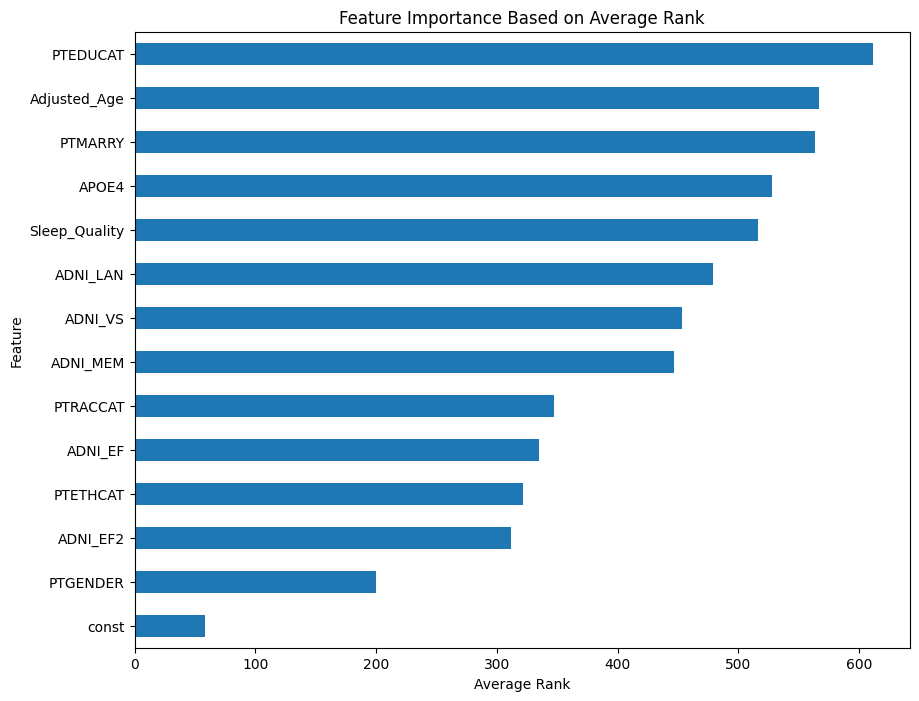

In [17]:
pivot_df['Average Rank'].sort_values().plot(kind='barh', figsize=(10, 8))
plt.xlabel('Average Rank')
plt.ylabel('Feature')
plt.title('Feature Importance Based on Average Rank')
plt.show()

In [18]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']


In [19]:
cognitive_results = []

for outcome in cognitive_outcomes:
    y = data_bl[outcome]
    model = sm.OLS(y, X).fit()
    print(f"\nResults for Cognitive Outcome: {outcome}")
    print(model.summary())
    
    for feature in X.columns:
        cognitive_results.append({
            'Outcome': outcome,
            'Feature': feature,
            'Coefficient': model.params[feature],
            'P-Value': model.pvalues[feature],
            'R-Squared': model.rsquared
        })

cognitive_results_df = pd.DataFrame(cognitive_results)


Results for Cognitive Outcome: ADNI_MEM
                            OLS Regression Results                            
Dep. Variable:               ADNI_MEM   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.935e+30
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:08:37   Log-Likelihood:                 16503.
No. Observations:                 522   AIC:                        -3.298e+04
Df Residuals:                     508   BIC:                        -3.292e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const

In [20]:
cognitive_results_df = cognitive_results_df[~cognitive_results_df['Feature'].isin(cognitive_outcomes)]
sorted_cognitive_results_df = cognitive_results_df.sort_values(by='Coefficient', ascending=False).groupby(['Outcome', 'Feature']).mean()

In [21]:
sorted_cognitive_results_df.groupby('Outcome').apply(lambda x: x.sort_values(by='Coefficient', ascending=False))

Coefficient   P-Value  R-Squared
Outcome  Outcome  Feature                                         
ADNI_EF  ADNI_EF  const          1.013079e-15  0.751532        1.0
                  PTGENDER       3.729655e-16  0.378651        1.0
                  PTMARRY        1.856154e-16  0.361552        1.0
                  APOE4          1.275022e-16  0.685036        1.0
                  PTEDUCAT       9.692767e-17  0.182104        1.0
                  PTETHCAT       3.426079e-17  0.982049        1.0
                  Adjusted_Age   2.764716e-17  0.387830        1.0
                  PTRACCAT      -1.500536e-16  0.810555        1.0
                  Sleep_Quality -2.207436e-16  0.457124        1.0
ADNI_EF2 ADNI_EF2 const          1.304512e-15  0.755055        1.0
                  PTGENDER       5.303917e-16  0.338076        1.0
                  PTMARRY        1.769418e-16  0.505607        1.0
                  PTETHCAT       1.674008e-16  0.932955        1.0
                  PTEDUCAT       1.265264e-16  0.182589        1.0
                  APOE4          1.231654e-16  0.764310        1.0
                  Adjusted_Age   3.686287e-17  0.378283        1.0
                  Sleep_Quality -3.226586e-16  0.405603        1.0
                  PTRACCAT      -4.020222e-16  0.623145        1.0
ADNI_LAN ADNI_LAN Sleep_Quality  7.001778e-16  0.002468        1.0
                  const          5.724587e-16  0.817615        1.0
                  PTRACCAT       2.216109e-16  0.648187        1.0
                  PTEDUCAT       1.505754e-16  0.007705        1.0
                  Adjusted_Age  -8.502856e-17  0.000662        1.0
                  PTMARRY       -1.015897e-16  0.519705        1.0
                  PTGENDER      -3.053113e-16  0.352947        1.0
                  APOE4         -3.694961e-16  0.130162        1.0
                  PTETHCAT      -9.332812e-16  0.429648        1.0
ADNI_MEM ADNI_MEM PTETHCAT       1.329449e-15  0.388457        1.0
                  PTGENDER       9.020562e-16  0.035709        1.0
                  Sleep_Quality  2.803747e-16  0.350774        1.0
                  PTMARRY        2.493936e-16  0.225908        1.0
                  PTEDUCAT       5.110319e-17  0.486700        1.0
                  APOE4          3.469447e-17  0.913152        1.0
                  Adjusted_Age  -9.822872e-17  0.002534        1.0
                  PTRACCAT      -1.491862e-16  0.813828        1.0
                  const         -1.925543e-16  0.952580        1.0
ADNI_VS  ADNI_VS  PTETHCAT       3.209238e-16  0.849155        1.0
                  PTEDUCAT       1.319474e-16  0.101336        1.0
                  APOE4          1.188286e-16  0.733005        1.0
                  PTMARRY        9.020562e-17  0.688951        1.0
                  PTRACCAT       8.283305e-17  0.904946        1.0
                  Adjusted_Age  -8.619407e-17  0.015375        1.0
                  const         -2.289835e-16  0.948505        1.0
                  Sleep_Quality -3.935654e-16  0.231748        1.0
                  PTGENDER      -6.609296e-16  0.159413        1.0

In [22]:
all_columns = data_bl.columns.tolist()

sleep_vars = [col for col in all_columns if any(sleep in col.lower() for sleep in [
                                                'sleep', 'npik', 'npiksev', 'apnea', 'insomnia', 'restless', 'disturbance'])]

print(f"Identified Sleep Variables: {sleep_vars}")

Identified Sleep Variables: ['NPIK', 'NPIKSEV', 'Sleep_Apnea', 'Restless_Legs', 'Insomnia', 'Sleep_Disturbance_Other', 'Sleep_Quality']


In [23]:
X_cols = sleep_vars + covariate_list

X = data_bl[X_cols]
X = sm.add_constant(X)

In [24]:
mri_outcomes = data_bl.columns.difference(
    ['RID', 'VISCODE2'] + sleep_vars + covariate_list).tolist()

print(f"Number of MRI Outcomes: {len(mri_outcomes)}")
print(f"Sample MRI Outcomes: {mri_outcomes[:5]}")

Number of MRI Outcomes: 125
Sample MRI Outcomes: ['Brainstem', 'CorpusCallosumAnterior', 'CorpusCallosumCentral', 'CorpusCallosumMidAnterior', 'CorpusCallosumMidPosterior']


In [25]:

label_encoders = {}
for column in X.select_dtypes(include=['object','category']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

X = sm.add_constant(X)

model_results = []
for outcome in mri_outcomes:
    y = data_bl[outcome]

    if y.dtype == 'object':
        le_y = LabelEncoder()
        y = le_y.fit_transform(y)
        label_encoders[outcome] = le_y

    model = sm.OLS(y, X).fit()

    for feature in X.columns:
        model_results.append({
            'Outcome': outcome,
            'Feature': feature,
            'Coefficient': model.params[feature],
            'P-Value': model.pvalues[feature],
            'R-Squared': model.rsquared
        })

results_df = pd.DataFrame(model_results)

c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [26]:
filtered_results_df = results_df[results_df['Outcome'].isin(['DX','DX_bl'])]
filtered_results_df.sort_values("Coefficient", ascending=False)[2:]

,Outcome,Feature,Coefficient,P-Value,R-Squared
163,DX_bl,Sleep_Apnea,0.678708,1.243135e-02,0.130887
143,DX,Sleep_Apnea,0.455587,1.108439e-01,0.266470
154,DX,ADNI_EF,0.307813,2.517121e-01,0.266470
169,DX_bl,PTGENDER,0.211477,2.335649e-03,0.130887
161,DX_bl,NPIK,0.202888,3.395258e-01,0.130887
146,DX,Sleep_Disturbance_Other,0.166157,7.249990e-01,0.266470
165,DX_bl,Insomnia,0.146550,6.556948e-01,0.130887
177,DX_bl,ADNI_EF2,0.137159,5.528006e-01,0.130887
167,DX_bl,Sleep_Quality,0.127492,3.843107e-01,0.130887
144,DX,Restless_Legs,0.126804,7.078894e-01,0.266470


In [27]:
merged_data = pd.merge(sleep_data, volumes_data, on=[
                       'RID', 'VISCODE'], how='inner')

In [28]:
sleep_vars = ['NPIK', 'NPIKSEV', 'Sleep_Apnea', 'Restless_Legs',
              'Insomnia', 'Sleep_Disturbance_Other', 'Sleep_Quality']
covariate_list = ['Adjusted_Age', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'APOE4',
                  'ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2',
                  'PTRACCAT', 'PTMARRY']

In [29]:
mri_outcomes = merged_data.columns.difference(
    ['RID', 'VISCODE2'] + sleep_vars + covariate_list).tolist()

In [30]:
print(f"Number of MRI Outcomes: {len(mri_outcomes)}")
print(f"Sample MRI Outcomes: {mri_outcomes[:5]}")  

Number of MRI Outcomes: 125
Sample MRI Outcomes: ['Brainstem', 'CorpusCallosumAnterior', 'CorpusCallosumCentral', 'CorpusCallosumMidAnterior', 'CorpusCallosumMidPosterior']


In [31]:
categorical_vars = ['PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'VISCODE']
merged_data[categorical_vars] = merged_data[categorical_vars].astype(
    'category')

In [32]:
predictors = ' + '.join(
    [f"C({var})" if var in categorical_vars else var for var in sleep_vars + covariate_list])

print(f"Final Predictor Formula: {predictors}")

Final Predictor Formula: NPIK + NPIKSEV + Sleep_Apnea + Restless_Legs + Insomnia + Sleep_Disturbance_Other + Sleep_Quality + Adjusted_Age + C(PTGENDER) + PTEDUCAT + C(PTETHCAT) + APOE4 + ADNI_MEM + ADNI_EF + ADNI_LAN + ADNI_VS + ADNI_EF2 + C(PTRACCAT) + C(PTMARRY)


In [33]:
duplicates = merged_data.duplicated(subset=['RID', 'VISCODE']).sum()
print(f"Number of Duplicates: {duplicates}")

missing_values = merged_data[['RID', 'VISCODE']].isnull().sum()
print("Missing Values in Key Columns:")
print(missing_values)

merged_data.drop_duplicates(subset=['RID', 'VISCODE'], inplace=True)
merged_data.dropna(subset=['RID', 'VISCODE'], inplace=True)

print(f"Shape after cleaning: {merged_data.shape}")

Number of Duplicates: 13
Missing Values in Key Columns:
RID        0
VISCODE    0
dtype: int64
Shape after cleaning: (2075, 145)


In [34]:
print(f"Number of unique RIDs: {merged_data['RID'].nunique()}")
print(f"Shape of merged data: {merged_data.shape}")
print(f"Unique VISCODE2 values: {merged_data['VISCODE'].unique()}")

Number of unique RIDs: 522
Shape of merged data: (2075, 145)
Unique VISCODE2 values: ['bl', 'm06', 'm12', 'm24']
Categories (4, object): ['bl', 'm06', 'm12', 'm24']


In [35]:
merged_data = merged_data.reset_index(drop=True)
# formula = f"{outcome} ~ {predictors} + C(VISCODE)"

In [36]:
categorical_vars = ['PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'VISCODE']

merged_data[categorical_vars] = merged_data[categorical_vars].astype(
    'category')

In [37]:
merged_data.select_dtypes(
    exclude=[np.number]).columns.tolist()

['VISCODE',
 'MHDESC',
 'Sleep_Quality',
 'DX_bl',
 'PTGENDER',
 'PTETHCAT',
 'PTRACCAT',
 'PTMARRY',
 'DX']

In [38]:
merged_data = merged_data.drop("MHDESC",axis=1)

In [39]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in merged_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    merged_data[column] = le.fit_transform(merged_data[column])
    label_encoders[column] = le

print("Object data in merged_data has been converted to label encoded values.")

Object data in merged_data has been converted to label encoded values.


In [40]:
merged_data['NPIKSEV'] = merged_data['NPIKSEV'].replace({-4.0:0})

In [41]:
merged_data.to_csv("Merged_data_modeling.csv",index=False)

In [42]:
sleep_vars = ['NPIK', 'NPIKSEV', 'Sleep_Apnea', 'Restless_Legs',
              'Insomnia', 'Sleep_Disturbance_Other', 'Sleep_Quality']

mri_outcomes = [col for col in merged_data.columns if col.startswith(
    ('Left', 'Right', 'Corpus', 'Brainstem', 'Csf', 'Icv','Fourth','NonWMH','Third','WMH','Optic'))]
print(mri_outcomes)

['Brainstem', 'CorpusCallosumAnterior', 'CorpusCallosumCentral', 'CorpusCallosumMidAnterior', 'CorpusCallosumMidPosterior', 'CorpusCallosumPosterior', 'Csf', 'RightParacentral', 'RightParahippocampal', 'RightParsOpercularis', 'RightParsOrbitalis', 'RightParsTriangularis', 'RightPericalcarine', 'RightPostcentral', 'RightPosteriorCingulate', 'RightPrecentral', 'RightPrecuneus', 'RightRostralAnteriorCingulate', 'RightRostralMiddleFrontal', 'RightSuperiorFrontal', 'RightSuperiorParietal', 'RightSuperiorTemporal', 'RightSupramarginal', 'RightTemporalPole', 'RightTransverseTemporal', 'RightUnknown', 'LeftInsula', 'RightInsula', 'LeftBankssts', 'LeftCaudalAnteriorCingulate', 'LeftCaudalMiddleFrontal', 'LeftCuneus', 'LeftEntorhinal', 'LeftFrontalPole', 'LeftFusiform', 'LeftInferiorParietal', 'LeftInferiorTemporal', 'LeftIsthmusCingulate', 'LeftLateralOccipital', 'LeftLateralOrbitofrontal', 'LeftLingual', 'LeftMedialOrbitofrontal', 'LeftMiddleTemporal', 'LeftParacentral', 'LeftParahippocampal',

In [43]:
psychometric_vars = ['ADNI_MEM', 'ADNI_EF', 'ADNI_VS', 'ADNI_LAN', 'ADNI_EF2']
sociodemo_outcomes = ['Adjusted_Age', 'PTGENDER', 'PTEDUCAT',
                      'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4']

In [44]:
target_groups = {
    'MRI': mri_outcomes,
    'Psychometric': psychometric_vars,
    'Sociodemographic': sociodemo_outcomes
}

In [45]:
timepoints = ['bl', 'm06', 'm12', 'm24']

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization


def build_dense_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(output_dim, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse', metrics=['mae'])
    return model

In [53]:
from sklearn.preprocessing import StandardScaler


def prepare_data_for_timepoint(df, viscode, feature_cols, target_cols):
    df_timepoint = df[df['VISCODE'] == viscode].dropna(
        subset=feature_cols + target_cols)

    X = df_timepoint[feature_cols].to_numpy()

    y = df_timepoint[target_cols].copy()
    label_encoders = {}

    for col in target_cols:
        if y[col].dtype == 'object' or y[col].dtype.name == 'category':
            le = LabelEncoder()
            y[col] = le.fit_transform(y[col].astype(str))
            label_encoders[col] = le

    y = y.to_numpy()

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)

    if len(y.shape) == 1 or y.shape[1] == 1 or np.issubdtype(y.dtype, np.number):
        y_scaled = scaler_y.fit_transform(y)
    else:
        y_scaled = y 

    print(
        f"Data prepared for VISCODE {viscode}: X shape: {X_scaled.shape}, y shape: {y_scaled.shape}")
    return X_scaled, y_scaled, scaler_X, scaler_y, label_encoders

In [48]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1)

results_df = pd.DataFrame(columns=[
                          'Outcome_Type', 'VISCODE', 'Model_Type', 'Loss', 'MAE', 'Val_Loss', 'Val_MAE'])


def train_dense_model(X, y, outcome_type, viscode):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = build_dense_model(input_dim=X_train.shape[1],
                              output_dim=y_train.shape[1])

    print(f"Training Dense Model for {outcome_type} at {viscode}...")
    history = model.fit(
        X_train, y_train, epochs=100, batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    val_loss = history.history['val_loss'][-1]
    val_mae = history.history['val_mae'][-1]

    print(
        f"Dense {outcome_type} Model for {viscode} -> Loss: {loss}, MAE: {mae}, Val_Loss: {val_loss}, Val_MAE: {val_mae}")

    results_df.loc[len(results_df)] = {
        'Outcome_Type': outcome_type,
        'VISCODE': viscode,
        'Model_Type': 'Dense',
        'Loss': loss,
        'MAE': mae,
        'Val_Loss': val_loss,
        'Val_MAE': val_mae
    }

    return model

In [49]:
def train_ensemble_model(X, y, outcome_type, viscode, model_type='RandomForest'):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    if model_type == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'XGBoost':
        model = XGBRegressor(
            n_estimators=100, learning_rate=0.1, random_state=42)

    print(f"Training {model_type} Model for {outcome_type} at {viscode}...")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    loss = np.mean((y_pred - y_test) ** 2)
    mae = np.mean(np.abs(y_pred - y_test))

    print(
        f"{model_type} {outcome_type} Model for {viscode} -> Loss: {loss}, MAE: {mae}")

    results_df.loc[len(results_df)] = {
        'Outcome_Type': outcome_type,
        'VISCODE': viscode,
        'Model_Type': model_type,
        'Loss': loss,
        'MAE': mae,
        'Val_Loss': loss,
        'Val_MAE': mae
    }

    return model

In [54]:
for viscode in timepoints:
    X_mri, y_mri, scaler_X_mri, scaler_y_mri, label_encoders_mri = prepare_data_for_timepoint(
        merged_data, viscode, sleep_vars, mri_outcomes)
    if len(X_mri) > 0 and len(y_mri) > 0:
        model_mri_dense = train_dense_model(X_mri, y_mri, 'MRI', viscode)
        model_mri_rf = train_ensemble_model(
            X_mri, y_mri, 'MRI', viscode, model_type='RandomForest')
        model_mri_xgb = train_ensemble_model(
            X_mri, y_mri, 'MRI', viscode, model_type='XGBoost')

    X_psych, y_psych, scaler_X_psych, scaler_y_psych, label_encoders_psych = prepare_data_for_timepoint(
        merged_data, viscode, sleep_vars, psychometric_vars)
    if len(X_psych) > 0 and len(y_psych) > 0:
        model_psych_dense = train_dense_model(
            X_psych, y_psych, 'Psychometric', viscode)
        model_psych_rf = train_ensemble_model(
            X_psych, y_psych, 'Psychometric', viscode, model_type='RandomForest')
        model_psych_xgb = train_ensemble_model(
            X_psych, y_psych, 'Psychometric', viscode, model_type='XGBoost')

    X_socio, y_socio, scaler_X_socio, scaler_y_socio, label_encoders_socio = prepare_data_for_timepoint(
        merged_data, viscode, sleep_vars, sociodemo_outcomes)
    if len(X_socio) > 0 and len(y_socio) > 0:
        model_socio_dense = train_dense_model(
            X_socio, y_socio, 'Sociodemographic', viscode)
        model_socio_rf = train_ensemble_model(
            X_socio, y_socio, 'Sociodemographic', viscode, model_type='RandomForest')
        model_socio_xgb = train_ensemble_model(
            X_socio, y_socio, 'Sociodemographic', viscode, model_type='XGBoost')

Data prepared for VISCODE bl: X shape: (520, 7), y shape: (520, 116)
Training Dense Model for MRI at bl...

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Dense MRI Model for bl -> Loss: 1.0311633348464966, MAE: 0.7962709069252014, Val_Loss: 1.0312814712524414, Val_MAE: 0.7963041663169861
Training RandomForest Model for MRI at bl...
RandomForest MRI Model for bl -> Loss: 1.0327134351931992, MAE: 0.7964095210672679
Training XGBoost Model for MRI at bl...
XGBoost MRI Model for bl -> Loss: 1.032522190383721, MAE: 0.7959718246840213
Data prepared for VISCODE bl: X shape: (520, 7), y shape: (520, 5)
Training Dense Model for Psychometric at bl...

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Dense Psychometric Model for bl -> Loss: 1.1213409900665283, MAE: 0.8373094201087952, V

In [55]:
results_df.groupby(['Outcome_Type', 'Model_Type']).mean()

C:\Users\anisr\AppData\Local\Temp\ipykernel_14484\505318023.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df.groupby(['Outcome_Type', 'Model_Type']).mean()


Loss       MAE  Val_Loss   Val_MAE
Outcome_Type     Model_Type                                          
MRI              Dense         1.039077  0.799638  1.039420  0.799745
                 RandomForest  1.048034  0.802744  1.048034  0.802744
                 XGBoost       1.052000  0.803859  1.052000  0.803859
Psychometric     Dense         1.089367  0.828210  1.097827  0.831571
                 RandomForest  1.113390  0.841264  1.113390  0.841264
                 XGBoost       1.115650  0.841923  1.115650  0.841923
Sociodemographic Dense         1.010749  0.688325  1.017887  0.681532
                 RandomForest  1.029067  0.679224  1.029067  0.679224
                 XGBoost       1.033970  0.681564  1.033970  0.681564

In [56]:
merged_data['DX_bl'].value_counts()

2    946
1    708
0    421
Name: DX_bl, dtype: int64

In [57]:
dx_bl_encoder = label_encoders['DX_bl']
{index: label for index, label in enumerate(dx_bl_encoder.classes_)}


{0: 'AD', 1: 'CN', 2: 'LMCI'}

In [58]:
cn_data = merged_data[merged_data['DX_bl'] == 1]
mci_data = merged_data[merged_data['DX_bl'] == 2]
ad_data = merged_data[merged_data['DX_bl'] == 0]

In [59]:
cn_data = cn_data.sort_values(by=['RID', 'VISCODE'])
mci_data = mci_data.sort_values(by=['RID', 'VISCODE'])
ad_data = ad_data.sort_values(by=['RID', 'VISCODE'])

In [60]:
print(f"CN Data Shape: {cn_data.shape}")
print(f"MCI Data Shape: {mci_data.shape}")
print(f"AD Data Shape: {ad_data.shape}")

CN Data Shape: (708, 144)
MCI Data Shape: (946, 144)
AD Data Shape: (421, 144)


In [70]:
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import pearsonr



def perform_granger_causality(df, var1, var2, max_lag=3):
    """
    Perform Granger Causality Test to assess bidirectional relationship.
    Returns p-values for Granger causality in both directions.
    """
    try:
        data = df[[var1, var2]].dropna()
        result_1 = grangercausalitytests(data, max_lag, verbose=False)
        p_val_1 = result_1[1][0]['ssr_ftest'][1]

        result_2 = grangercausalitytests(
            data[[var2, var1]].dropna(), max_lag, verbose=False)
        p_val_2 = result_2[1][0]['ssr_ftest'][1]

        return p_val_1, p_val_2
    except Exception as e:
        return np.nan, np.nan

In [ ]:
def calculate_correlation(df, var1, var2):
    """
    Calculate Pearson correlation between two variables.
    Convert non-numeric columns to numeric before correlation.
    """
    corr_df = df[[var1, var2]].dropna()

    corr_df[var1] = pd.to_numeric(corr_df[var1], errors='coerce')
    corr_df[var2] = pd.to_numeric(corr_df[var2], errors='coerce')

    corr_df = corr_df.dropna()

    if not corr_df.empty and len(corr_df) > 1:
        corr_value, p_value = pearsonr(corr_df[var1], corr_df[var2])
        return corr_value, p_value
    else:
        return np.nan, np.nan

In [76]:
group_data = {
    'CN': cn_data,
    'MCI': mci_data,
    'AD': ad_data
}

In [90]:
results_list = []
for group_name, group_df in group_data.items():
    print(f"Analyzing {group_name} Group...")

    for sleep_var in sleep_vars:
        for outcome in mri_outcomes + psychometric_vars + sociodemo_outcomes:
            p_val_1, p_val_2 = perform_granger_causality(
                group_df, sleep_var, outcome)

            corr_value, corr_p_value = calculate_correlation(
                group_df, sleep_var, outcome)

            results_list.append({
                'Group': group_name,
                'Sleep_Variable': sleep_var,
                'Outcome': outcome,
                'Metric': 'Correlation',
                'Value': corr_value,
                'p_value': corr_p_value
            })

            results_list.append({
                'Group': group_name,
                'Sleep_Variable': sleep_var,
                'Outcome': outcome,
                'Metric': 'Sleep_to_Outcome',
                'Value': p_val_1,
                'p_value': p_val_1
            })

            results_list.append({
                'Group': group_name,
                'Sleep_Variable': sleep_var,
                'Outcome': outcome,
                'Metric': 'Outcome_to_Sleep',
                'Value': p_val_2,
                'p_value': p_val_2
            })


Analyzing CN Group...


c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmod

Analyzing MCI Group...


c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmod

Analyzing AD Group...


c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\anisr\anaconda3\envs\research\lib\site-packages\statsmod

In [91]:
results_df = pd.DataFrame(results_list)
results_df.head()

,Group,Sleep_Variable,Outcome,Metric,Value,p_value
0,CN,NPIK,Brainstem,Correlation,-0.025655,0.495535
1,CN,NPIK,Brainstem,Sleep_to_Outcome,0.977393,0.977393
2,CN,NPIK,Brainstem,Outcome_to_Sleep,0.185149,0.185149
3,CN,NPIK,CorpusCallosumAnterior,Correlation,-0.048513,0.197284
4,CN,NPIK,CorpusCallosumAnterior,Sleep_to_Outcome,0.993264,0.993264


In [97]:
import seaborn as sns 


def plot_correlation_heatmap(results_df, group_name, outcome_type, top_n=20):
   
    group_df = results_df[
        (results_df['Group'] == group_name) &
        (results_df['Metric'] == 'Correlation') &
        (results_df['Outcome'].isin(outcome_type))
    ].sort_values(by='Value', ascending=False).head(top_n)

    if group_df.empty:
        print(f"No correlation data found for {group_name} - {outcome_type}")
        return

    pivot_df = group_df.pivot(
        index='Sleep_Variable', columns='Outcome', values='Value')
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='coolwarm', cbar=True)
    plt.title(f'Top {top_n} Correlations for {group_name}')
    plt.xlabel('Outcome Variables')
    plt.ylabel('Sleep Variables')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [98]:
def plot_granger_heatmap(results_df, group_name, outcome_type, direction, top_n=20):

    group_df = results_df[
        (results_df['Group'] == group_name) &
        (results_df['Metric'] == direction) &
        (results_df['Outcome'].isin(outcome_type))
    ].sort_values(by='Value', ascending=True).head(top_n)

    if group_df.empty:
        print(
            f"No Granger Causality data found for {group_name} - {direction} - {outcome_type}")
        return

    pivot_df = group_df.pivot(
        index='Sleep_Variable', columns='Outcome', values='Value')
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='coolwarm', cbar=True)
    plt.title(f'Top {top_n} Granger Causality - {direction.replace("_", " ")} for {group_name}')
    plt.xlabel('Outcome Variables')
    plt.ylabel('Sleep Variables')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [99]:
mri_outcomes = list(mri_outcomes) 
psychometric_outcomes = list(psychometric_vars)
sociodemographic_outcomes = list(
    sociodemo_outcomes)  

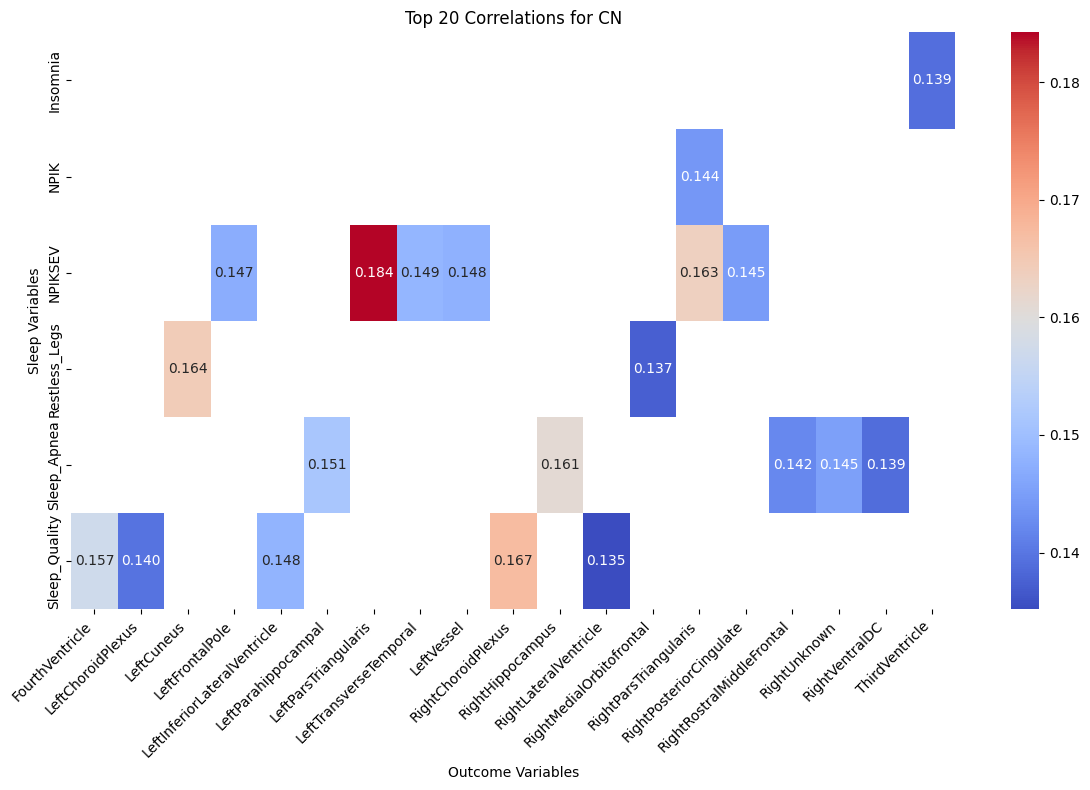

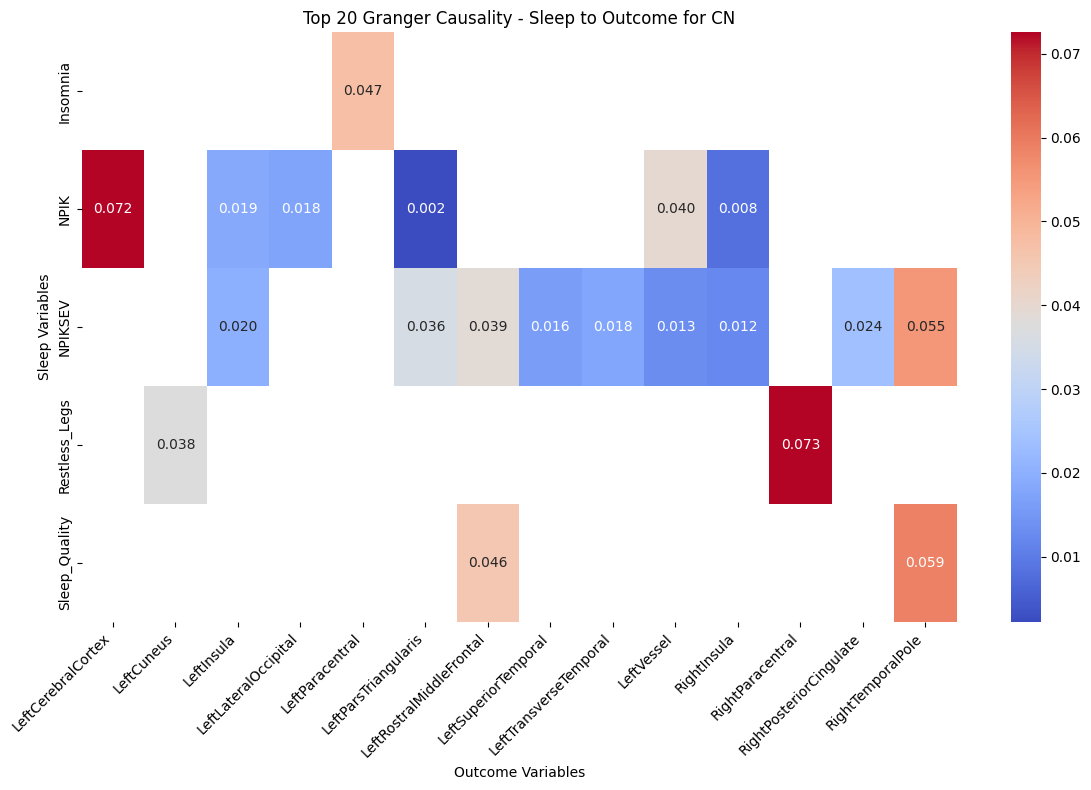

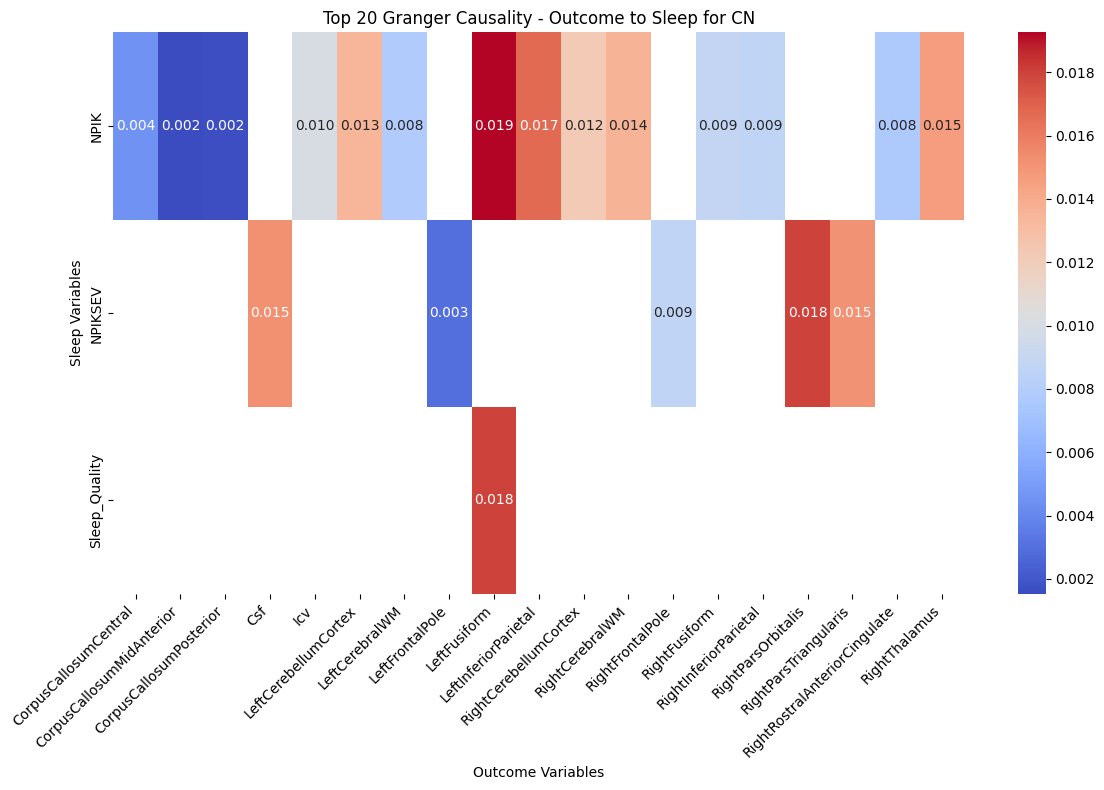

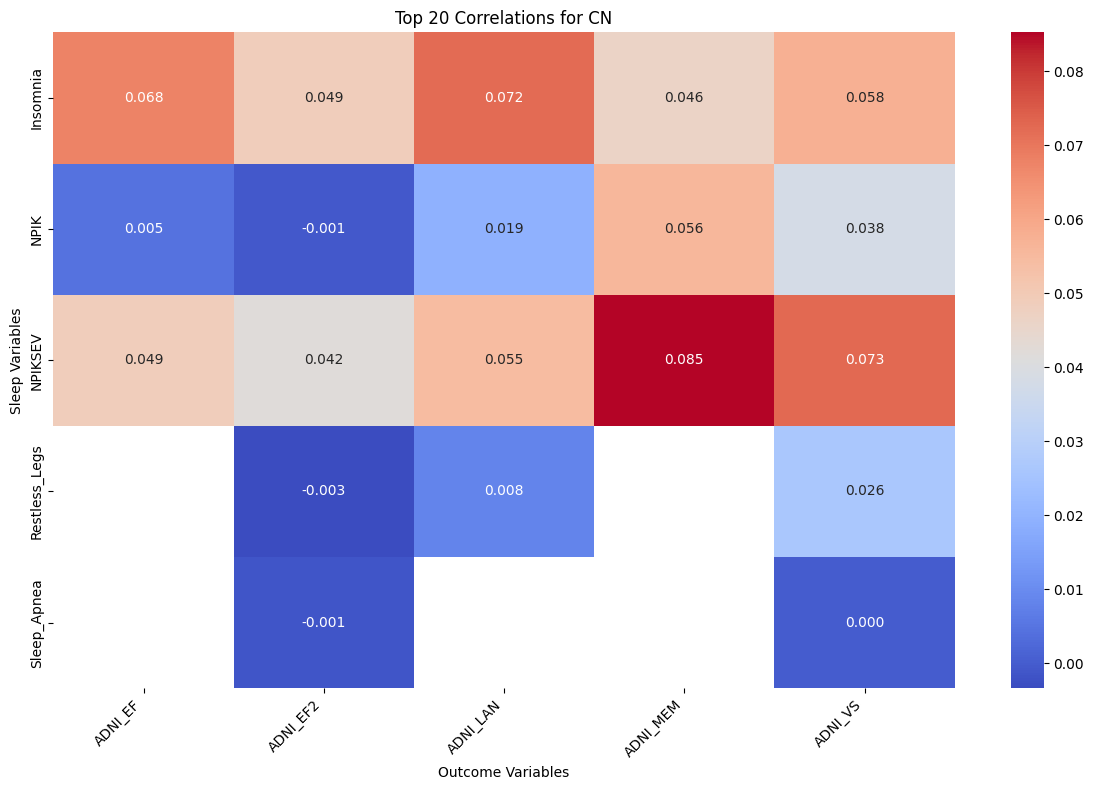

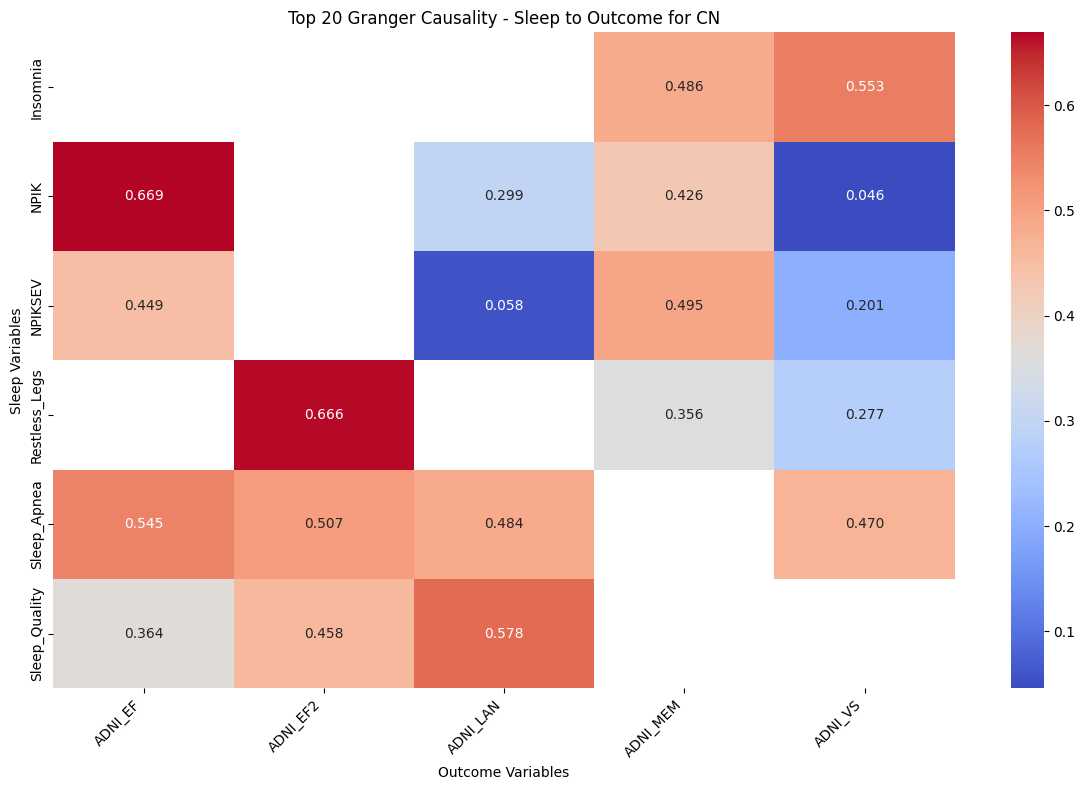

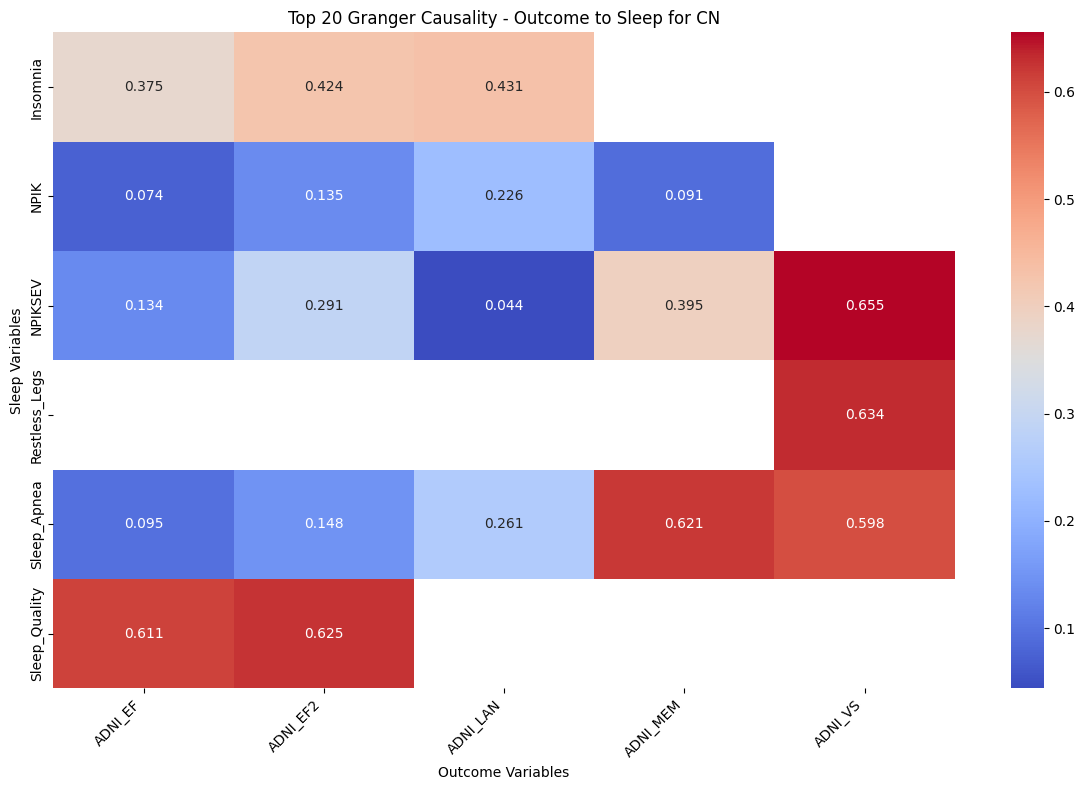

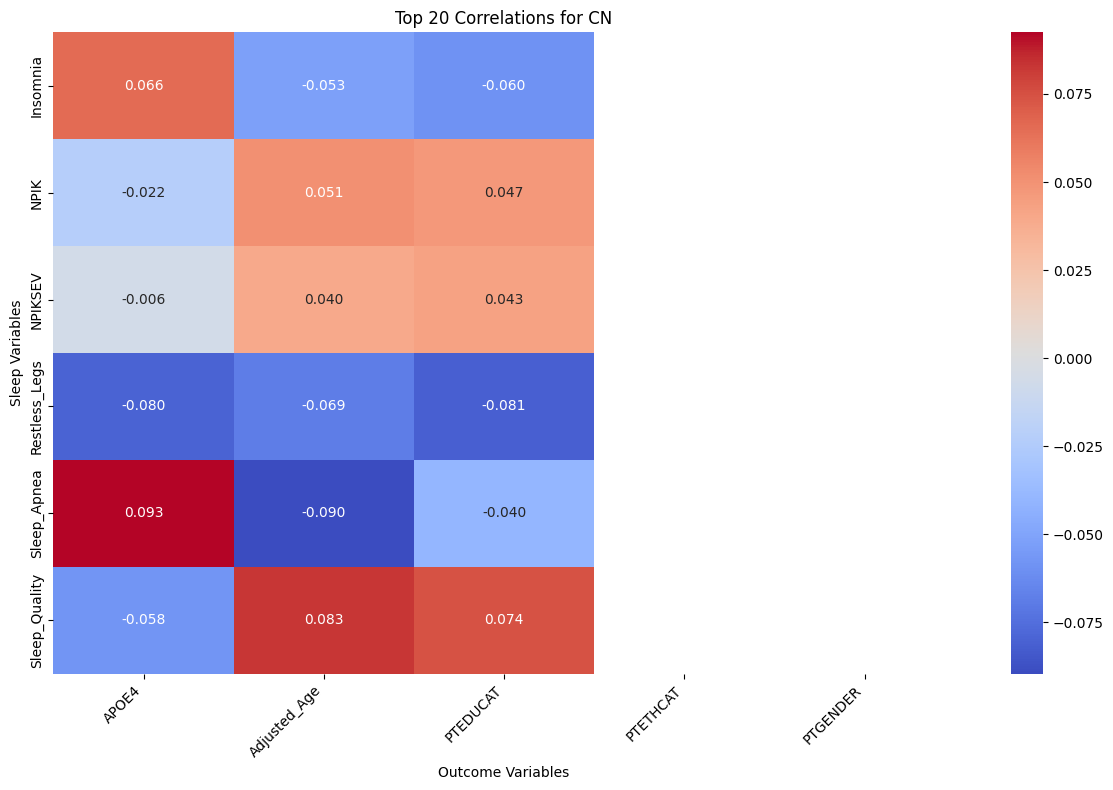

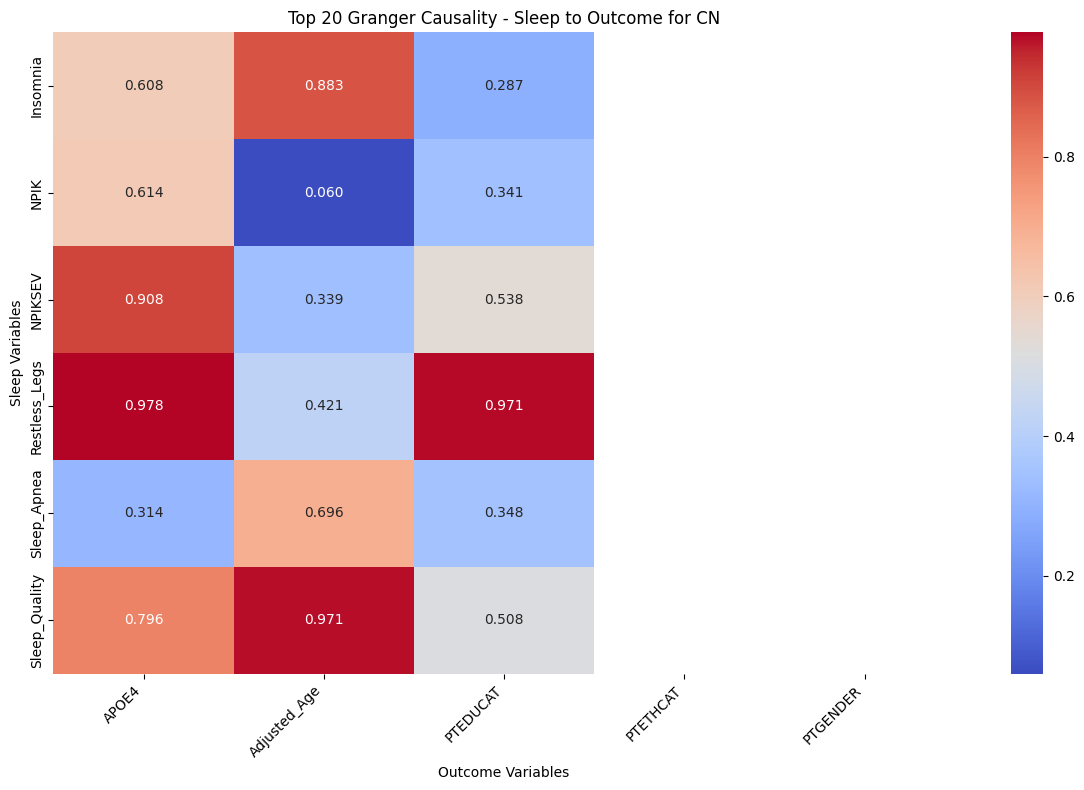

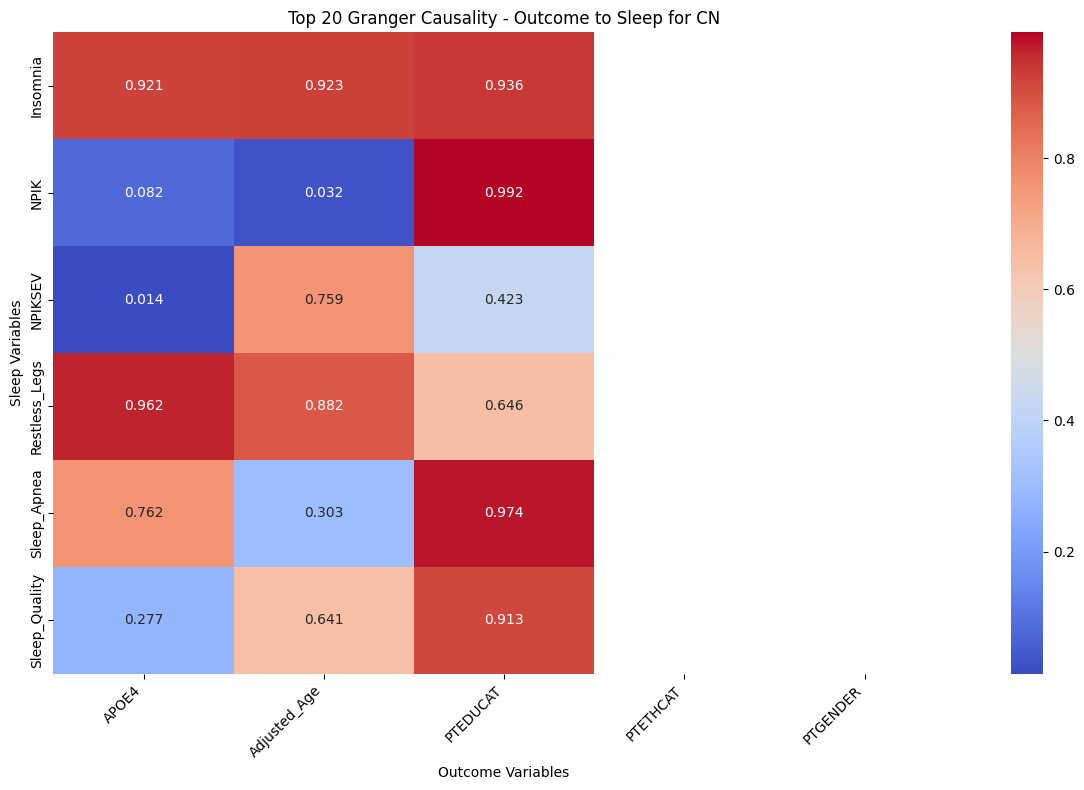

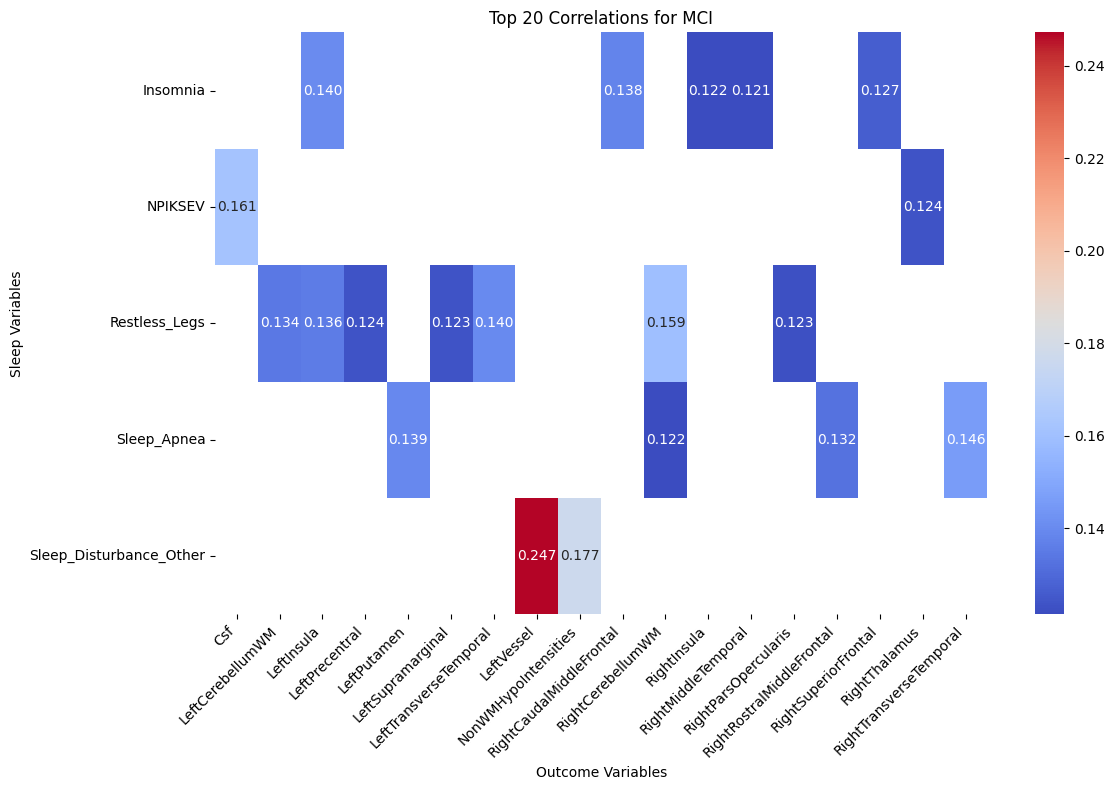

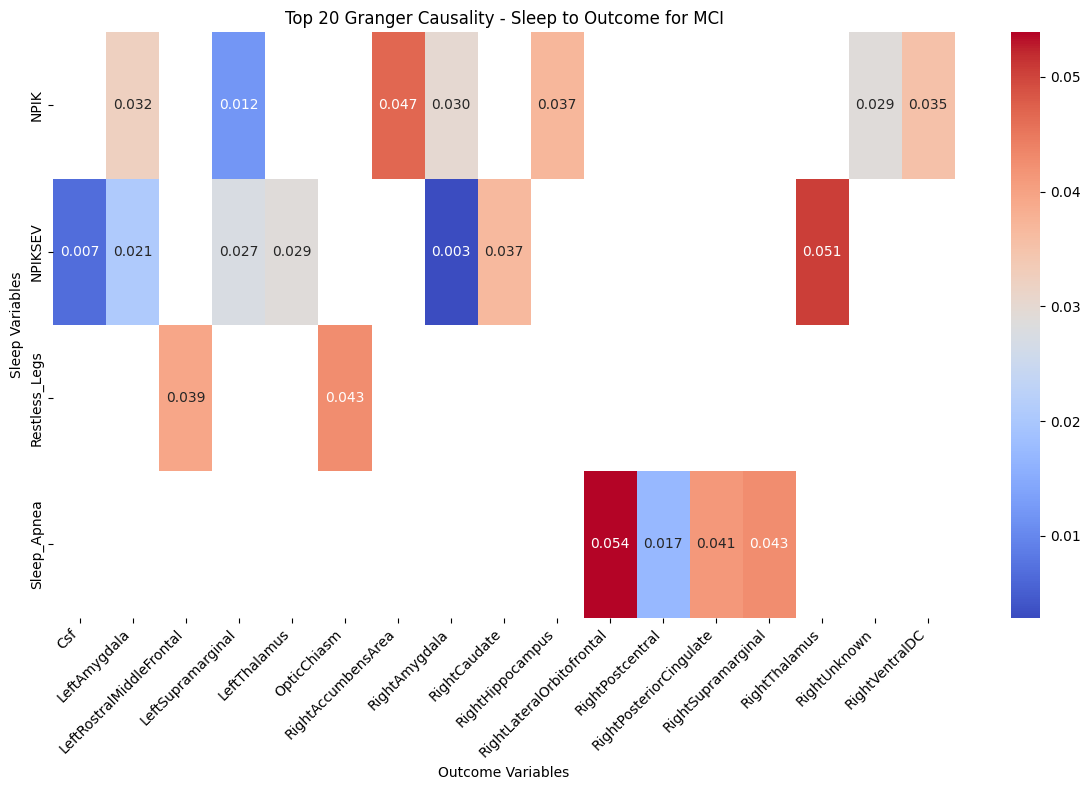

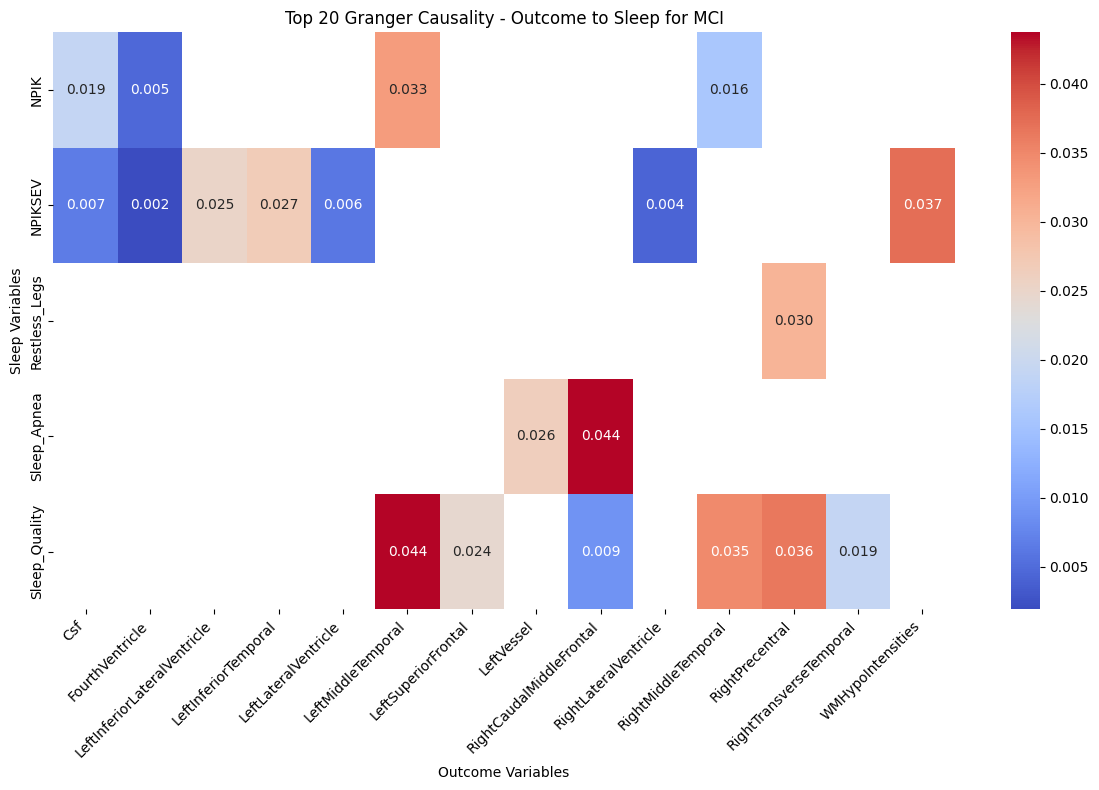

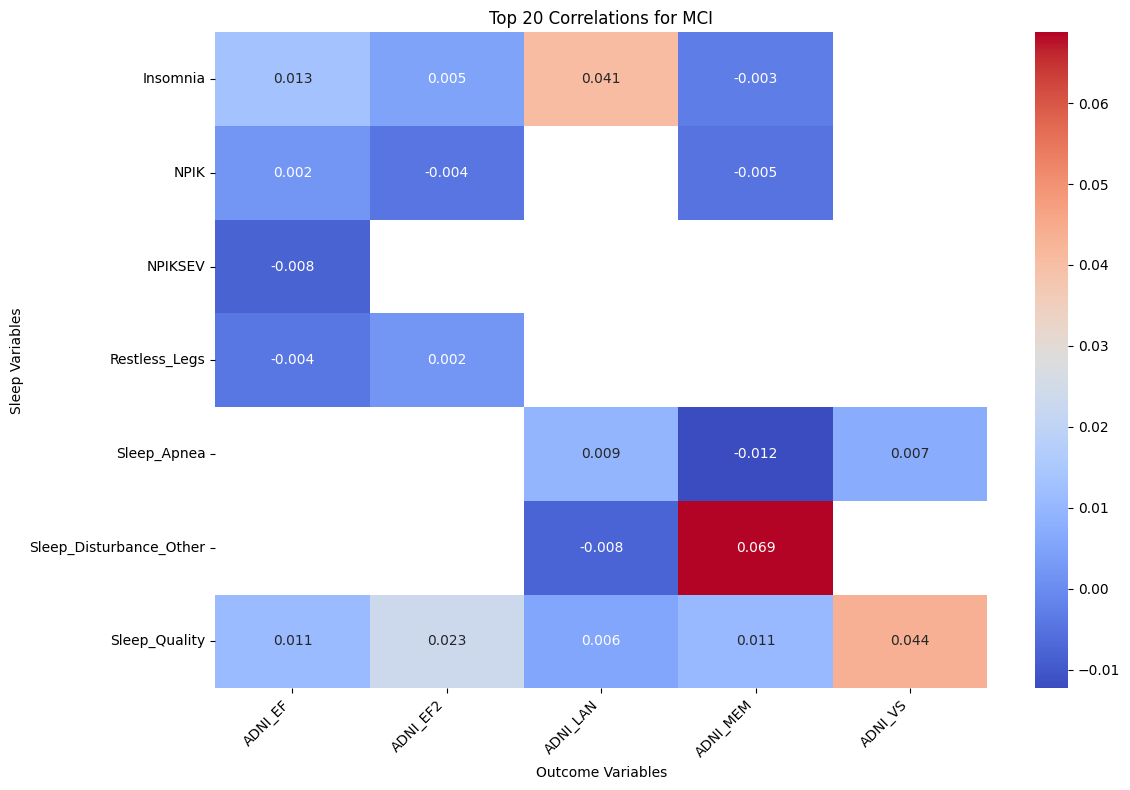

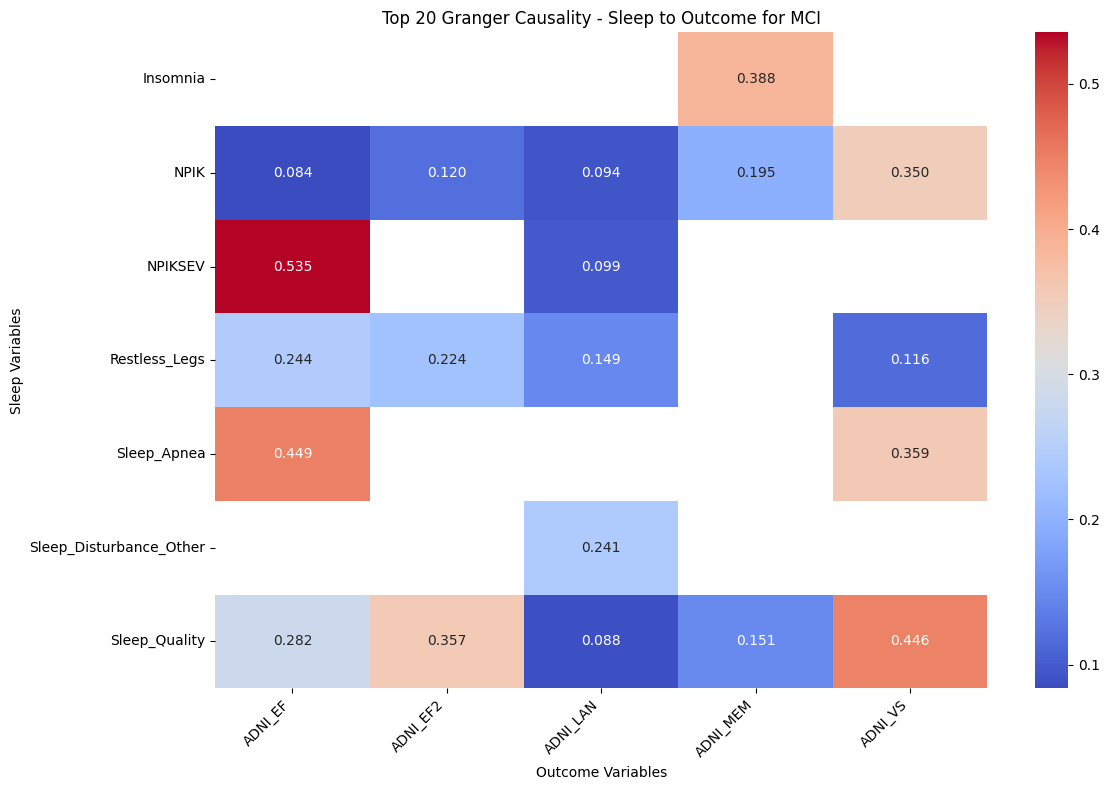

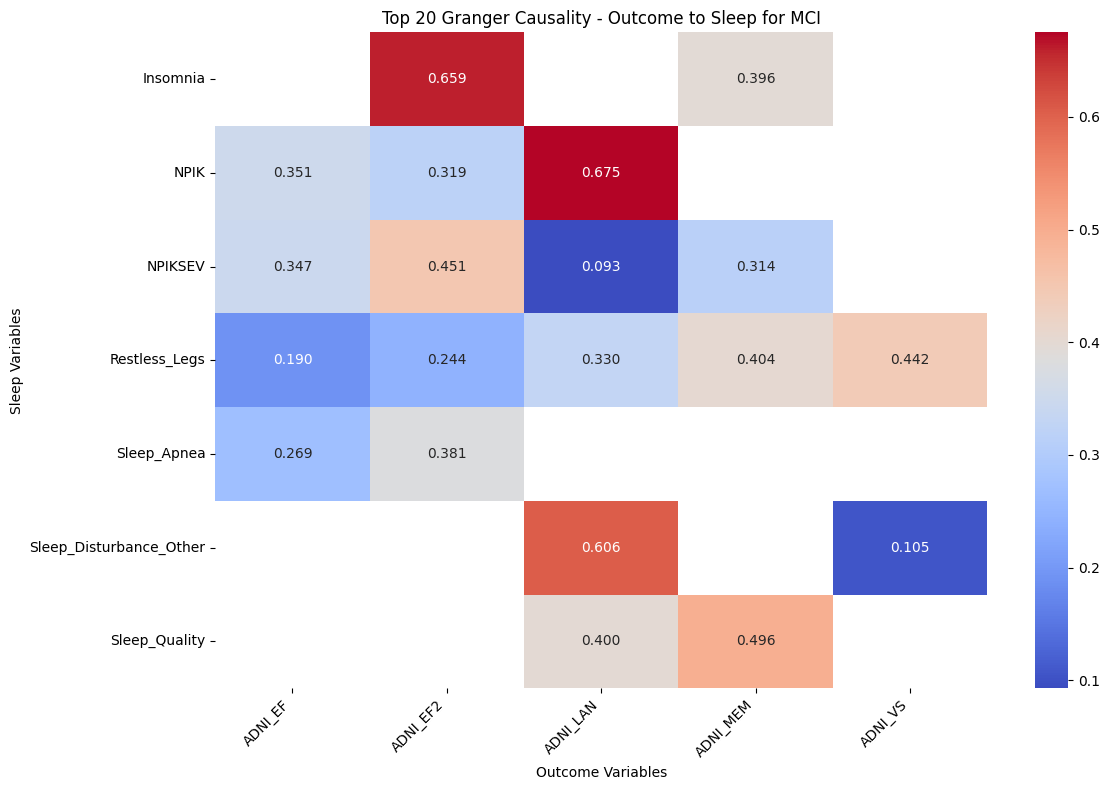

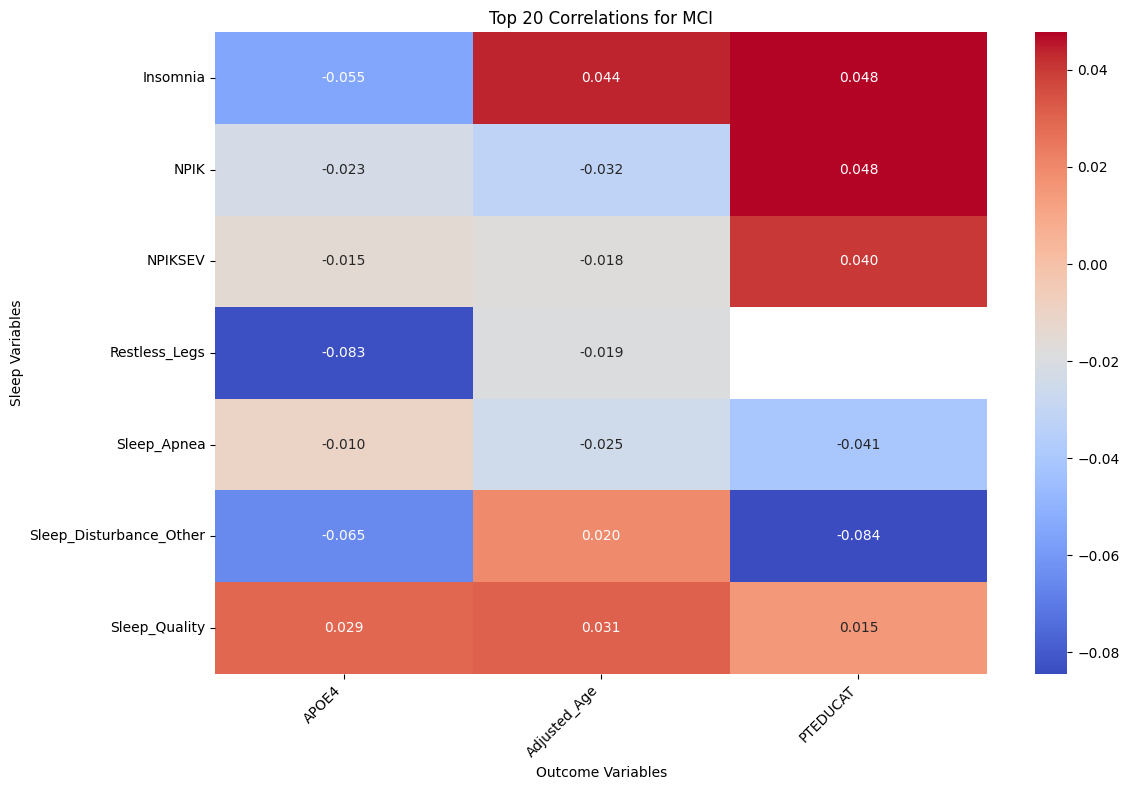

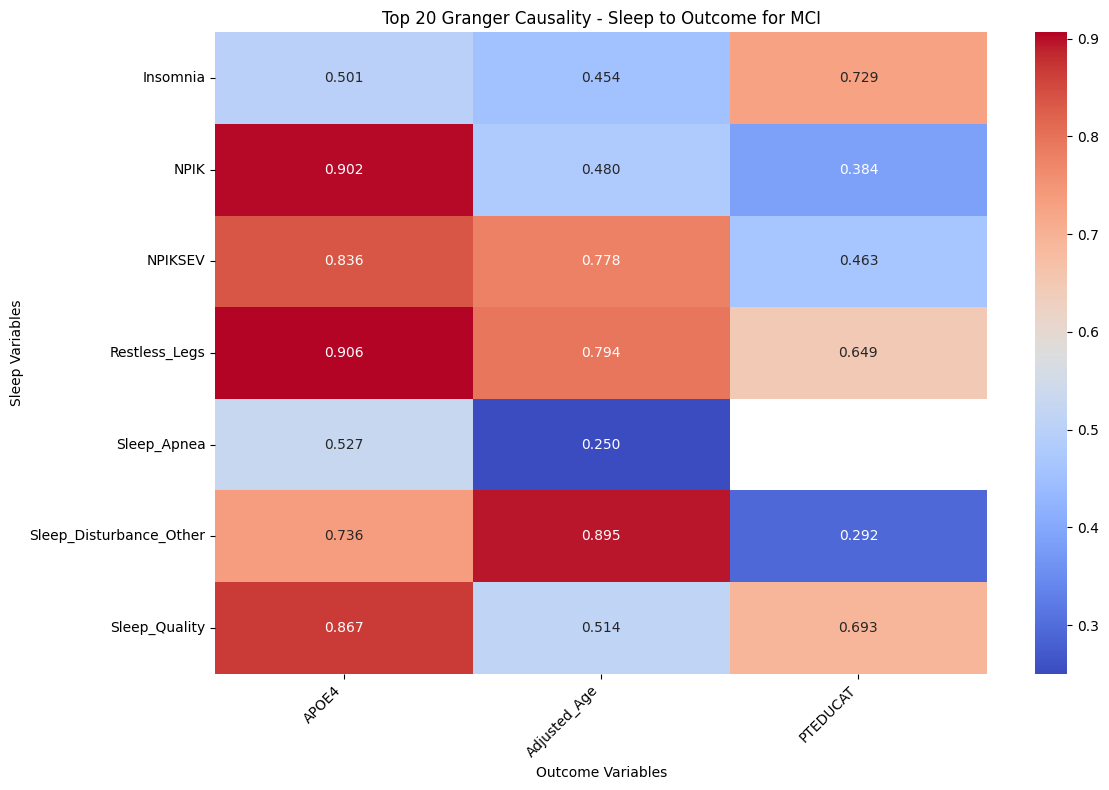

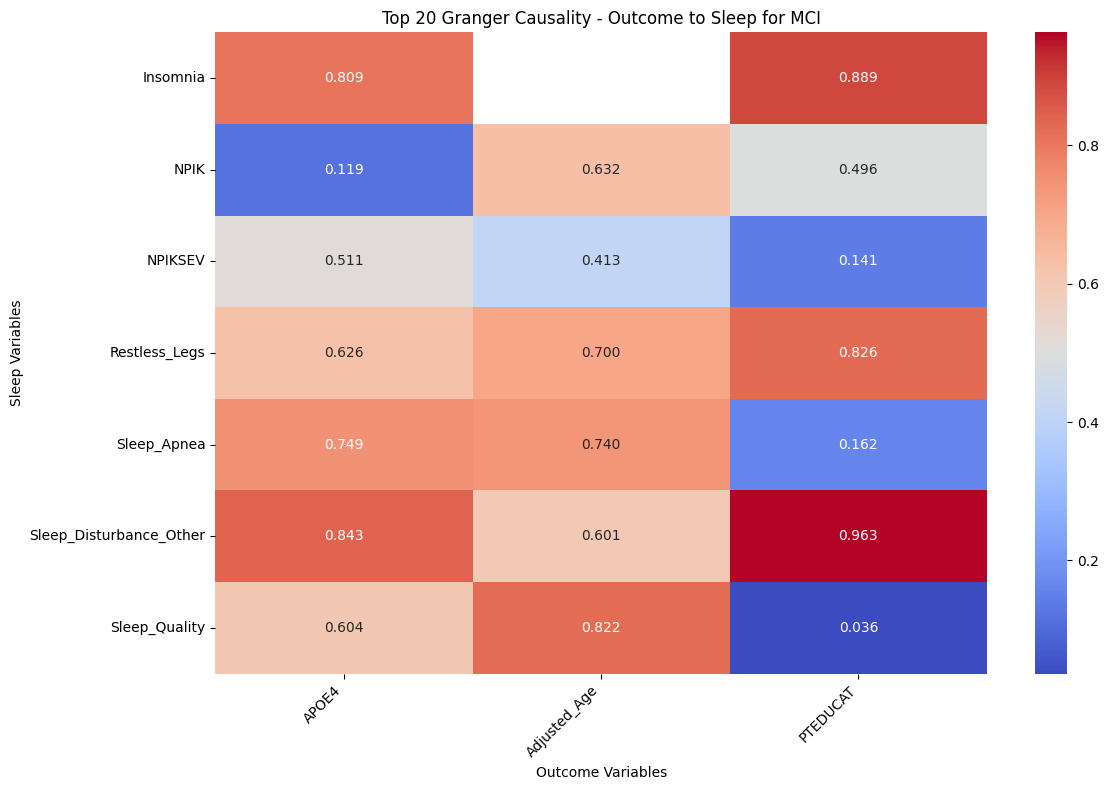

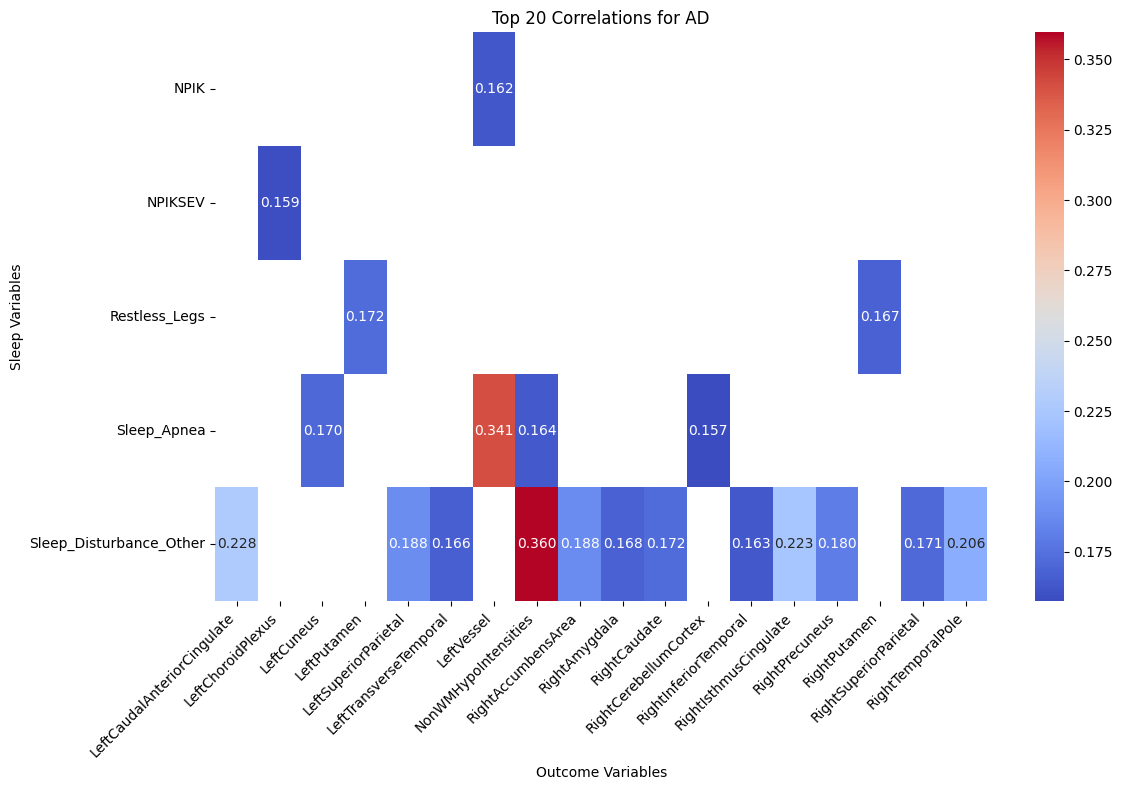

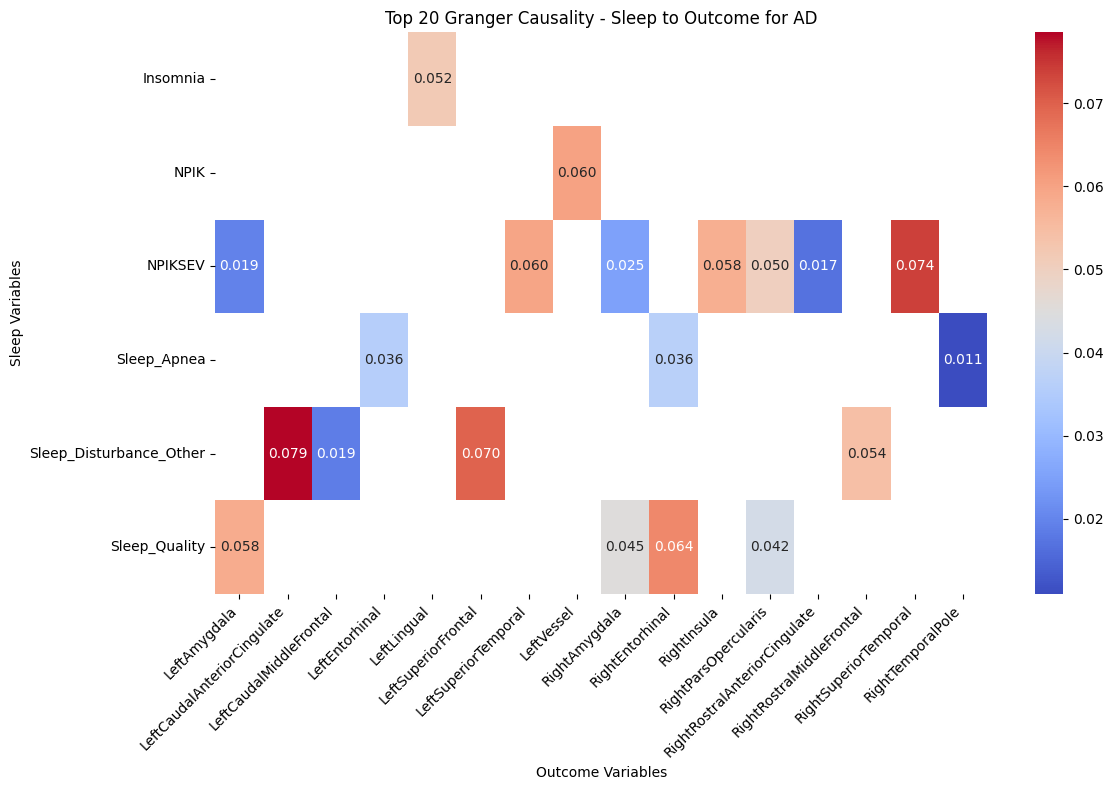

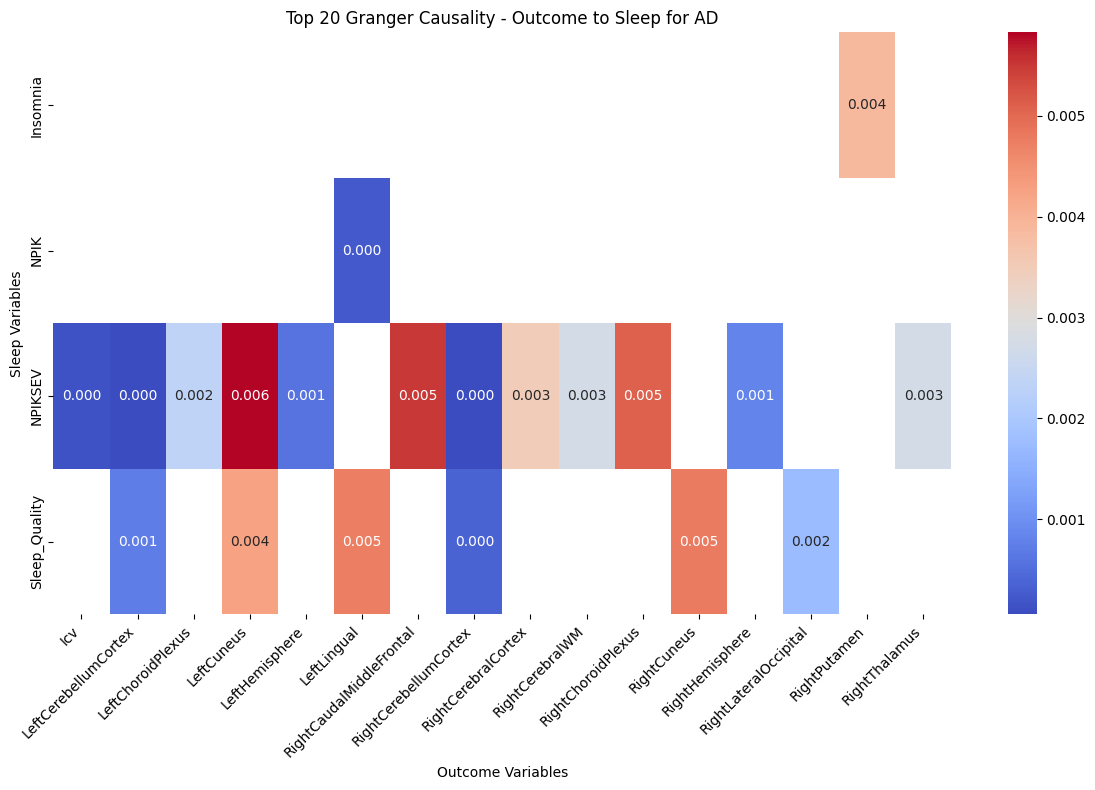

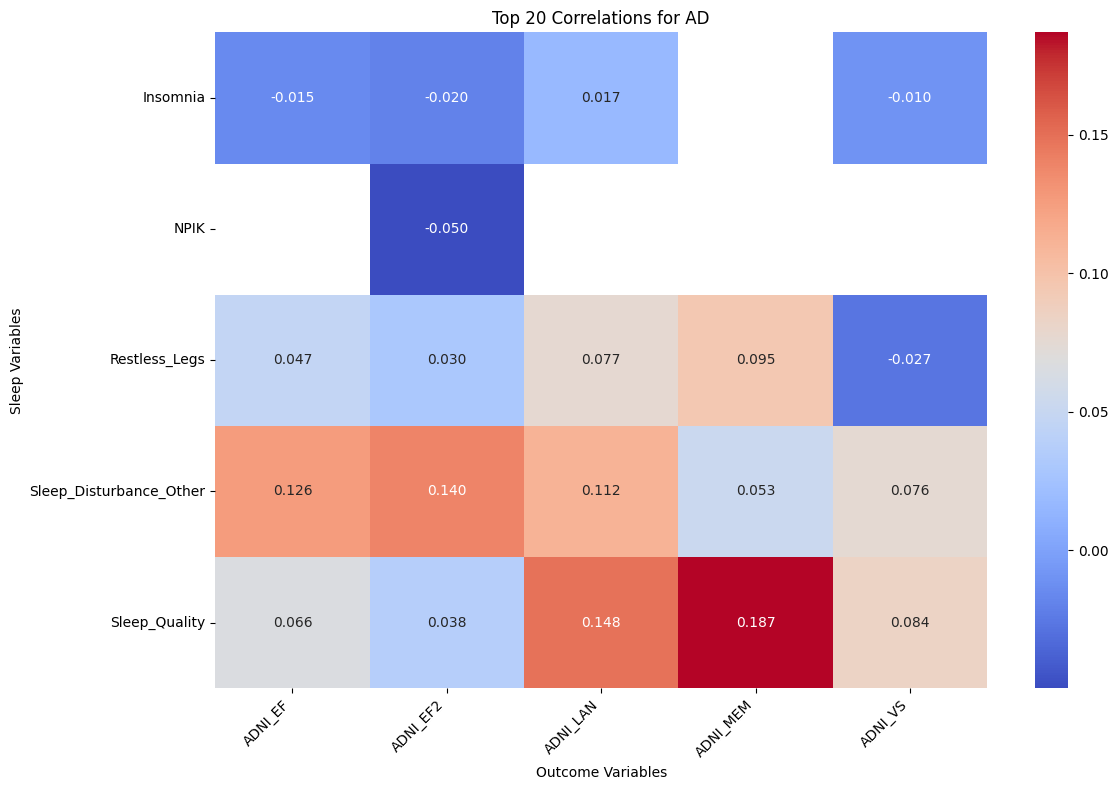

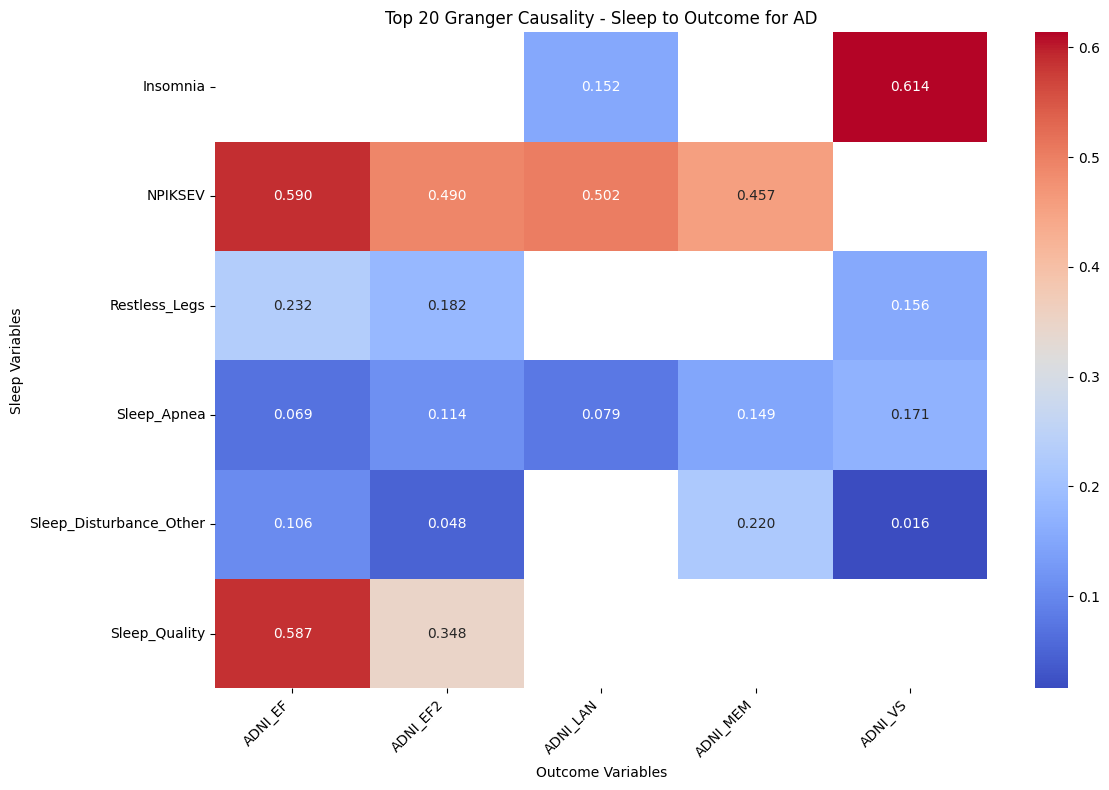

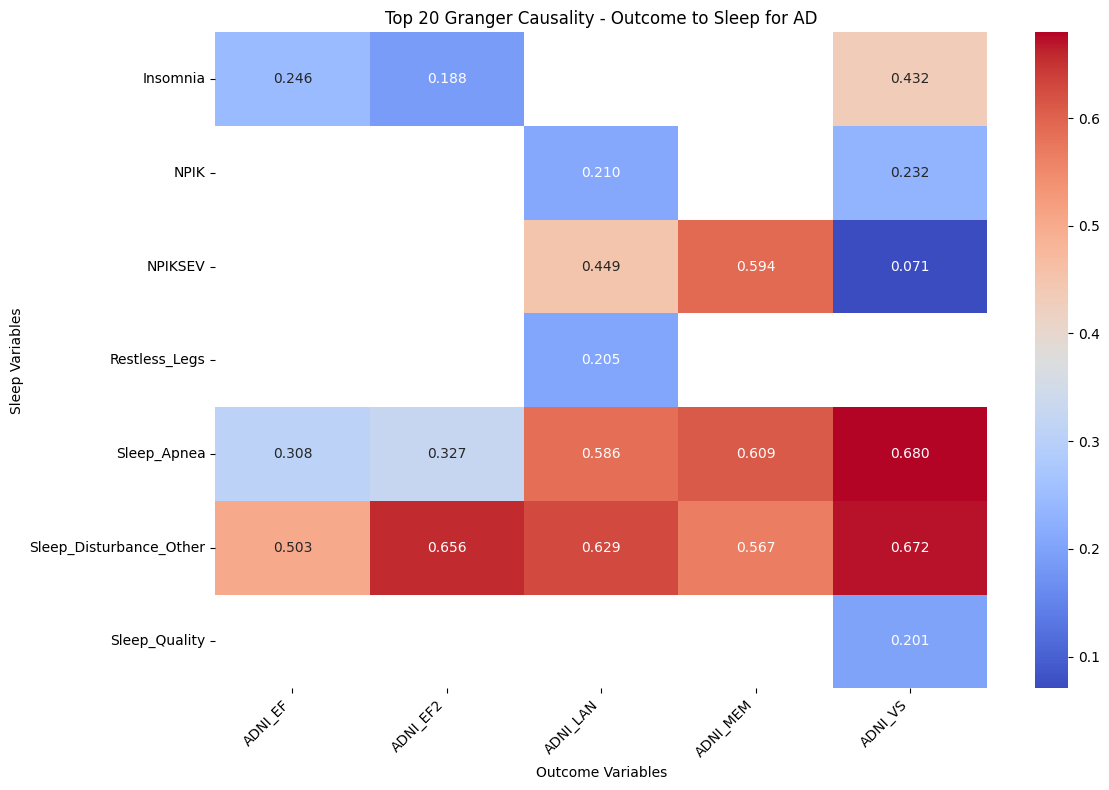

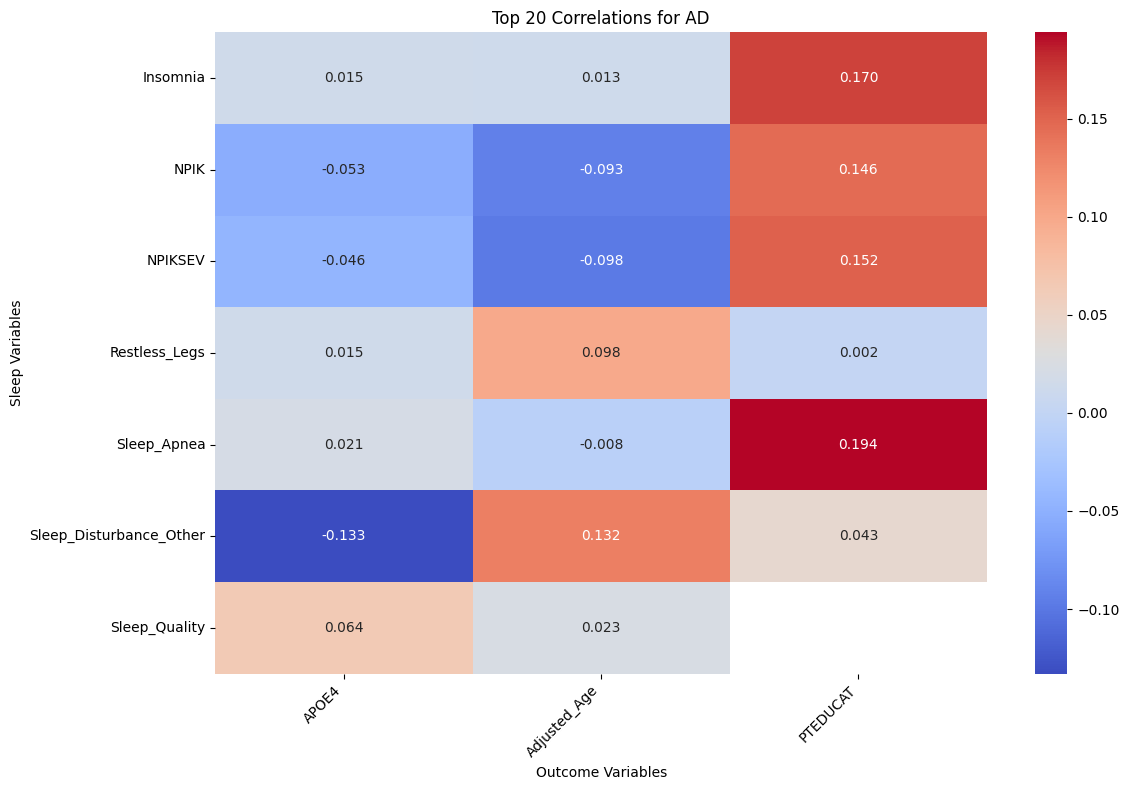

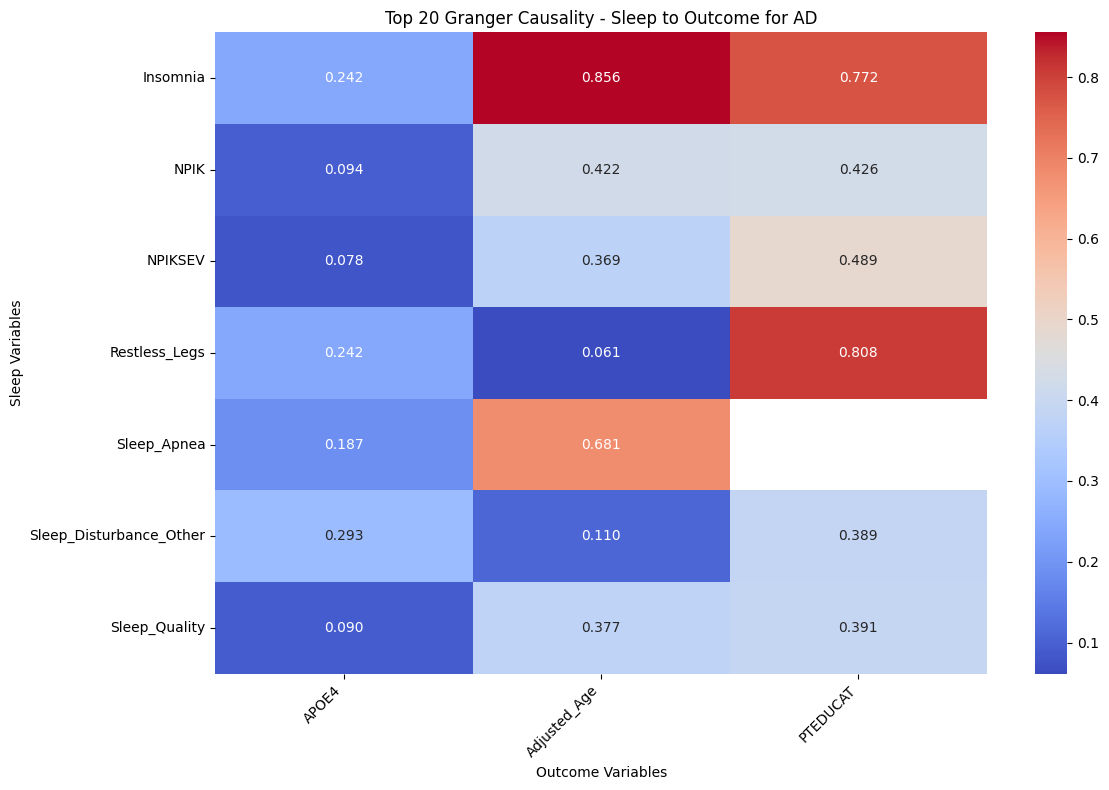

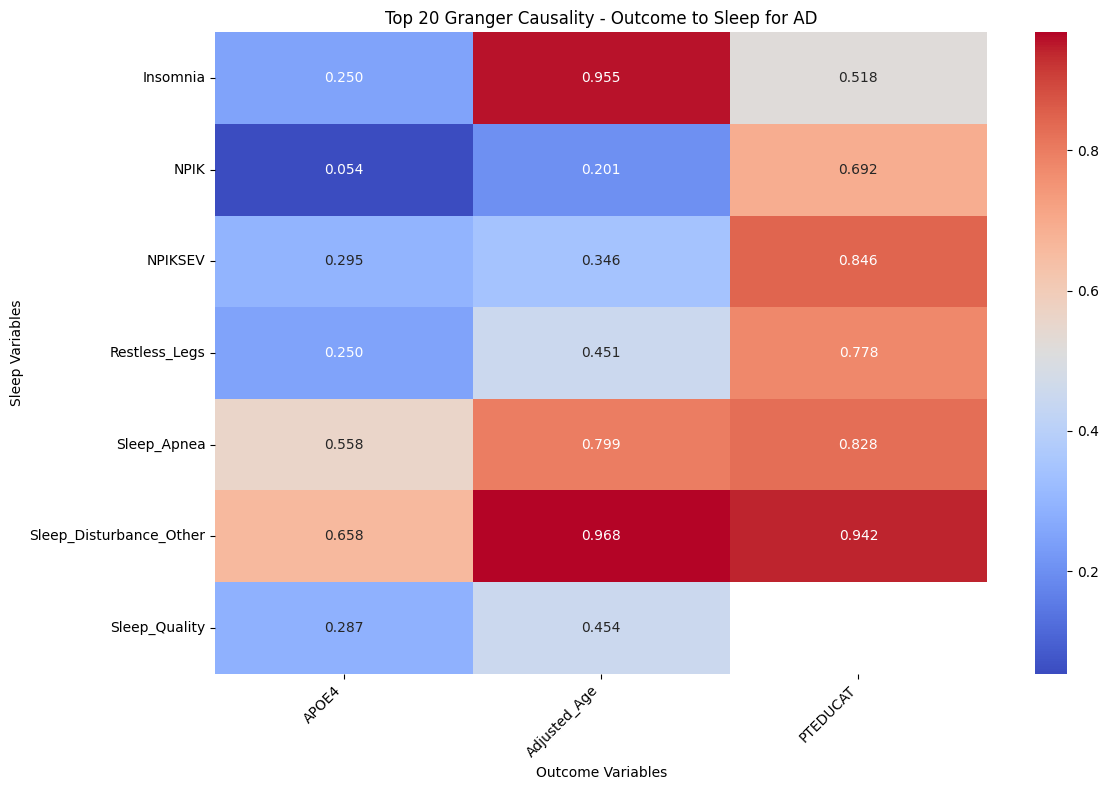

In [ ]:
top_n = 20  

for group_name in group_data.keys():  
    plot_correlation_heatmap(
        results_df, group_name, mri_outcomes, top_n=top_n)
    plot_granger_heatmap(
        results_df, group_name, mri_outcomes, direction='Sleep_to_Outcome', top_n=top_n)
    plot_granger_heatmap(
        results_df, group_name, mri_outcomes, direction='Outcome_to_Sleep', top_n=top_n)

    plot_correlation_heatmap(
        results_df, group_name, psychometric_outcomes, top_n=top_n)
    plot_granger_heatmap(
        results_df, group_name, psychometric_outcomes, direction='Sleep_to_Outcome', top_n=top_n)
    plot_granger_heatmap(
        results_df, group_name, psychometric_outcomes, direction='Outcome_to_Sleep', top_n=top_n)

    plot_correlation_heatmap(
        results_df, group_name, sociodemographic_outcomes, top_n=top_n)
    plot_granger_heatmap(
        results_df, group_name, sociodemographic_outcomes, direction='Sleep_to_Outcome', top_n=top_n)
    plot_granger_heatmap(
        results_df, group_name, sociodemographic_outcomes, direction='Outcome_to_Sleep', top_n=top_n)

In [102]:
cn_results_df = results_df[results_df['Group'] == 'CN'].copy()
mci_results_df = results_df[results_df['Group'] == 'MCI'].copy()
ad_results_df = results_df[results_df['Group'] == 'AD'].copy()

def get_top_results(df, metric, top_n=20):
    return df[df['Metric'] == metric].sort_values(
        by='Value', ascending=(metric != 'Correlation')
    ).head(top_n)


top_metrics = ['Correlation', 'Sleep_to_Outcome', 'Outcome_to_Sleep']

top_cn_corr_df = get_top_results(cn_results_df, 'Correlation')
top_cn_granger_s2o_df = get_top_results(cn_results_df, 'Sleep_to_Outcome')
top_cn_granger_o2s_df = get_top_results(cn_results_df, 'Outcome_to_Sleep')

top_mci_corr_df = get_top_results(mci_results_df, 'Correlation')
top_mci_granger_s2o_df = get_top_results(mci_results_df, 'Sleep_to_Outcome')
top_mci_granger_o2s_df = get_top_results(mci_results_df, 'Outcome_to_Sleep')

top_ad_corr_df = get_top_results(ad_results_df, 'Correlation')
top_ad_granger_s2o_df = get_top_results(ad_results_df, 'Sleep_to_Outcome')
top_ad_granger_o2s_df = get_top_results(ad_results_df, 'Outcome_to_Sleep')

In [103]:
cn_final_df = pd.concat([
    top_cn_corr_df, top_cn_granger_s2o_df, top_cn_granger_o2s_df
]).sort_values(by='Value', ascending=False).reset_index(drop=True)

mci_final_df = pd.concat([
    top_mci_corr_df, top_mci_granger_s2o_df, top_mci_granger_o2s_df
]).sort_values(by='Value', ascending=False).reset_index(drop=True)

ad_final_df = pd.concat([
    top_ad_corr_df, top_ad_granger_s2o_df, top_ad_granger_o2s_df
]).sort_values(by='Value', ascending=False).reset_index(drop=True)

In [107]:
cn_final_df.to_csv('Supplementary_tables/cn_results.csv', index=False)
mci_final_df.to_csv('Supplementary_tables/mci_results.csv', index=False)
ad_final_df.to_csv('Supplementary_tables/ad_results.csv', index=False)

In [7]:
pd.read_csv("supplementary_tables/cn_results.csv").sort_values(by=['Metric','Value'])

,Group,Sleep_Variable,Outcome,Metric,Value,p_value
19,CN,Sleep_Quality,RightLateralVentricle,Correlation,0.135155,3.104290e-04
18,CN,Restless_Legs,RightMedialOrbitofrontal,Correlation,0.137385,2.458754e-04
17,CN,Sleep_Apnea,RightVentralDC,Correlation,0.138964,2.080317e-04
16,CN,Insomnia,ThirdVentricle,Correlation,0.139043,2.062845e-04
15,CN,Sleep_Quality,LeftChoroidPlexus,Correlation,0.139647,1.934097e-04
14,CN,Sleep_Apnea,RightRostralMiddleFrontal,Correlation,0.142241,1.462155e-04
13,CN,NPIK,RightParsTriangularis,Correlation,0.143993,1.207091e-04
12,CN,NPIKSEV,RightPosteriorCingulate,Correlation,0.144649,1.122862e-04
11,CN,Sleep_Apnea,RightUnknown,Correlation,0.145190,1.057593e-04
10,CN,NPIKSEV,LeftFrontalPole,Correlation,0.147130,8.517308e-05


In [8]:
pd.read_csv("supplementary_tables/mci_results.csv").sort_values(by=['Metric', 'Value'])

,Group,Sleep_Variable,Outcome,Metric,Value,p_value
19,MCI,Insomnia,RightMiddleTemporal,Correlation,0.121423,1.814485e-04
18,MCI,Sleep_Apnea,RightCerebellumWM,Correlation,0.121763,1.739663e-04
17,MCI,Insomnia,RightInsula,Correlation,0.121789,1.734030e-04
16,MCI,Restless_Legs,RightParsOpercularis,Correlation,0.122609,1.565819e-04
15,MCI,Restless_Legs,LeftSupramarginal,Correlation,0.123420,1.414689e-04
14,MCI,Restless_Legs,LeftPrecentral,Correlation,0.123613,1.380842e-04
13,MCI,NPIKSEV,RightThalamus,Correlation,0.123729,1.360816e-04
12,MCI,Insomnia,RightSuperiorFrontal,Correlation,0.126534,9.525554e-05
11,MCI,Sleep_Apnea,RightRostralMiddleFrontal,Correlation,0.132380,4.422550e-05
10,MCI,Restless_Legs,LeftCerebellumWM,Correlation,0.134371,3.379985e-05


In [ ]:
pd.read_csv("supplementary_tables/ad_results.csv").sort_values(by=['Metric', 'Value'])

,Group,Sleep_Variable,Outcome,Metric,Value,p_value
19,AD,Sleep_Disturbance_Other,RightInferiorTemporal,Correlation,0.163287,7.709974e-04
18,AD,Sleep_Apnea,NonWMHypoIntensities,Correlation,0.164492,7.036335e-04
17,AD,Sleep_Disturbance_Other,LeftTransverseTemporal,Correlation,0.166162,6.192327e-04
16,AD,Restless_Legs,RightPutamen,Correlation,0.167229,5.703424e-04
15,AD,Sleep_Disturbance_Other,RightAmygdala,Correlation,0.167649,5.520915e-04
14,AD,Sleep_Apnea,LeftCuneus,Correlation,0.170080,4.567183e-04
13,AD,Insomnia,PTEDUCAT,Correlation,0.170103,4.558936e-04
12,AD,Sleep_Disturbance_Other,RightSuperiorParietal,Correlation,0.171063,4.226638e-04
11,AD,Sleep_Disturbance_Other,RightCaudate,Correlation,0.171674,4.027471e-04
10,AD,Restless_Legs,LeftPutamen,Correlation,0.172106,3.891730e-04


: 

y = beta0 + beta1*sleep + beta2*sex + beta3*age
y is MRI volume say precuneus

we are estimating the betas

y = beta0 + beta1*sleep*group + beta2*sex + beta3*age
y = beta0 + beta1*sleep + beta12*group + beta13*group:sleep + beta2*sex + beta3*age

account for ICV, age, sex, education, BMI...